##Nuclei detection with Mask RCNN

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

from config import Config
import utils
import model as modellib
import visualize
import skimage.color
import skimage.io
from skimage.io import imread, imshow, imread_collection, concatenate_images
from model import log


%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
#if not os.path.exists(COCO_MODEL_PATH):
#    utils.download_trained_weights(COCO_MODEL_PATH)

/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


In [58]:
## Define RLE encoding functions
from skimage.morphology import label


def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)


def mask_encode(masks):
    n_mask = masks.shape[2]
    res = []
    for i in range(n_mask):
        encode_one = prob_to_rles(masks[:, :, i])
        res.extend(encode_one)
    return res

In [2]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [20]:
import matplotlib.patches as patches
from skimage.measure import find_contours
from matplotlib.patches import Polygon


def plot_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    figsize: (optional) the size of the image.
    """
    # Number of instances
    N_box = boxes.shape[0]
    N_mask = masks.shape[2]
    if not N_box:
        print("\n*** No instances to display *** \n")
    #else:
    #    assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)

    # Generate random colors
    colors_box = visualize.random_colors(N_box)
    colors_mask = visualize.random_colors(N_mask)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N_box):
        color = colors_box[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax.add_patch(p)

        # Label
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        x = random.randint(x1, (x1 + x2) // 2)
        caption = "{} {:.3f}".format(label, score) if score else label
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")
    for i in range(N_mask):
        # Mask
        mask = masks[:, :, i]
        color = colors_mask[i]
        masked_image = visualize.apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    plt.savefig("./plot/" + title + ".png", bbox_inches='tight')
    plt.close()

##Configuration

In [4]:
class NucleiConfig(Config):
    """Configuration for training on the nuclei dataset.
    Derives from the base Config class and overrides values specific
    to the toy nuclei dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Train on 1 GPU and 2 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    # Use the highest number that the GPU/CPU can handel ?
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 nuclei class

    # Set the limits of the small side
    # the large side, and that determines the image shape.
    # Image are resized such that the smallest side is >= the min dim 
    # the longest side is <= the max dim
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4, 16, 32, 64, 256)  # anchor side in pixels

    # Number of ROI per image to feed the classifier. The mask RCNN paper 
    # use 512 but often the RPN doesn't generate enough positive proposal
    # to fill this and keep a positive:negative ratio of 1:3.
    # The mean is about 60? choose 200 to keep the positive rate 33%
    TRAIN_ROIS_PER_IMAGE = 200

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    # Max number of final detection, adjust according to the distribution
    DETECTION_MAX_INSTANCES = 380
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        380
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  1024
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING   

## Dataset

Create a nuclei dataset



In [5]:
TRAIN_PATH = './kaggle-dsbowl-2018-dataset-fixes-master/stage1_train/'
TEST_PATH = './input/stage1_test/'
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]


In [6]:
# Function to remove overlapping portion of masks (keep the portion with higher score)


def remove_overlap(masks):
    n_masks = masks.shape[2]

    for i in range(n_masks):
        good_mask = masks[:, :, i]
        for j in range(i + 1, n_masks):
            fix_mask = masks[:, :, j]
            overlapping = (good_mask == 1) & (fix_mask == 1)
            if np.any(overlapping):
                print('Overlapping mask detected!')
                fix_mask[overlapping] = 0
                masks[:, :, j] = fix_mask
    return masks

In [7]:
#create the nuclei dataset

class NucleiDataset(utils.Dataset):
    
    def load_nuclei(self, path, ids):       
        #Add class
        self.add_class("nuclei", 1, "nuclei")

        # Add image
        for i in range(len(ids)):
            path_image = path + ids[i] + '/images/' + ids[i] + '.png'
            mask_path = path + ids[i] + '/masks/'
            self.add_image("nuclei", image_id=i, path=path_image, maskpath=mask_path)
     
     
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])[:, :, :3]
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image       
  
         
    def load_mask(self, i):
        img = self.load_image(i)
        width = img.shape[1]
        height = img.shape[0]
        n = len(next(os.walk(self.image_info[i]['maskpath']))[2])       
        mask = np.zeros((height, width, n), dtype=np.bool)
        for t, mask_file in enumerate(next(os.walk(self.image_info[i]['maskpath']))[2]):            
            mask_ = imread(self.image_info[i]['maskpath'] + mask_file)
            mask[:, :, t:t+1] = np.reshape(mask_,(height,width,1))
        class_ids = np.array([1]*n)
        return mask, class_ids
        

In [8]:
category = './input/classes.csv'
cate = pd.read_csv(category,index_col=False)
#print((cate['foreground'] == 'white') & (cate['background'] == 'black')) 
white_black = cate.loc[(cate['foreground'] == 'white') \
                       & (cate['background'] == 'black'),'filename'].tolist()
purple_yellow = cate.loc[(cate['foreground'] == 'purple') \
                       & (cate['background'] == 'yellow') ,'filename'].tolist()
purple_white = cate.loc[(cate['foreground'] == 'purple') \
                       & (cate['background'] == 'white') ,'filename'].tolist()
purple_purple = cate.loc[(cate['foreground'] == 'purple') \
                       & (cate['background'] == 'purple') ,'filename'].tolist()
black_white = cate.loc[(cate['foreground'] == 'black') \
                       & (cate['background'] == 'white') ,'filename'].tolist()

print("number of white_black image: %d" %len(white_black))
print("number of purple_yellow image: %d" %len(purple_yellow))
print("number of purple_white image: %d" %len(purple_white))
print("number of purple_purple image: %d" %len(purple_purple))
print("number of black_white image: %d" %len(black_white))


number of white_black image: 599
number of purple_yellow image: 8
number of purple_white image: 41
number of purple_purple image: 71
number of black_white image: 16


In [9]:
print(cate['filename'][1][:-4])

4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0


In [10]:
train_index = [n for i, n in enumerate(train_ids) \
               if n+".png" in white_black[:int(len(white_black)*0.8)]]
val_index = [n for i, n in enumerate(train_ids) \
             if n+".png" in white_black[int(len(white_black)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in purple_yellow[:int(len(purple_yellow)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in purple_yellow[int(len(purple_yellow)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in purple_white[:int(len(purple_white)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in purple_white[int(len(purple_white)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in purple_purple[:int(len(purple_purple)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in purple_purple[int(len(purple_purple)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in black_white[:int(len(black_white)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in black_white[int(len(black_white)*0.8):]]
print("length of train set: %d" %len(train_index))
print("length of validation set: %d" %len(val_index))
print(bool(set(val_index) & set(train_index)))

length of train set: 531
length of validation set: 133
False


In [11]:
#load the first 10 images
dataset_train = NucleiDataset()
dataset_train.load_nuclei(TRAIN_PATH, train_index)
dataset_train.prepare()

# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei(TRAIN_PATH, val_index) 
dataset_val.prepare()

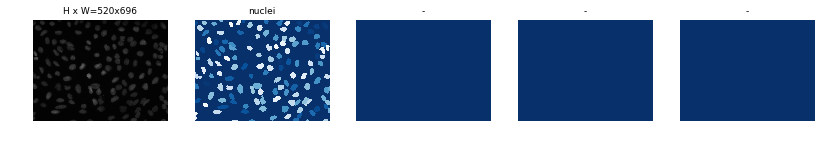

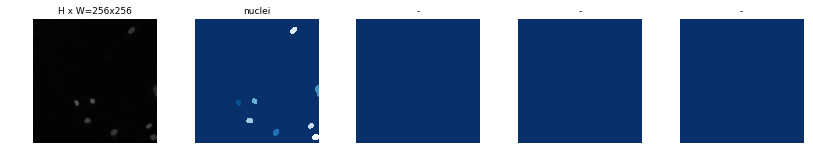

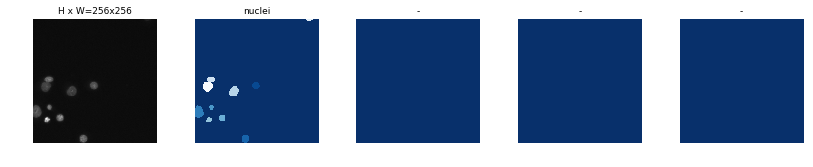

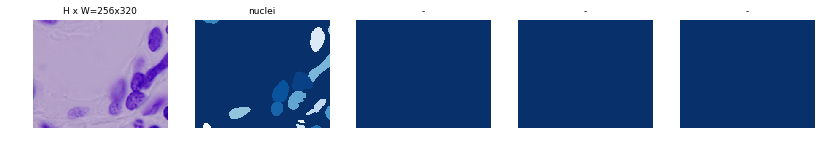

In [12]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


##Create model

In [41]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [47]:
# Which weights to start with? Used coco weights? 
init_with = "name"  # imagenet, coco, or last
model_name = 'mask_rcnn_nuclei_0326_1024pix_head_10epoch.h5'
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "name":
    # Load the last model you trained and continue training
    model.load_weights(os.path.join(MODEL_DIR, model_name), by_name=True)
print("loading:",model_name)

loading mask_rcnn_nuclei_0326_1024pix_head_10epoch.h5


##Training
Train in two stages:

Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.

In [65]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/yzu280/Documents/kaggle/Kaggle2018/logs/nuclei20180322T0013/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDis

/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


  1/100 [..............................] - ETA: 55:24 - loss: 7.6609 - rpn_class_loss: 0.9995 - rpn_bbox_loss: 2.2630 - mrcnn_class_loss: 2.4073 - mrcnn_bbox_loss: 1.2392 - mrcnn_mask_loss: 0.7519

ERROR:root:Error processing image {'id': 97, 'source': 'nuclei', 'path': './input/stage1_train/a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288/images/a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288.png', 'maskpath': './input/stage1_train/a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288/masks/'}
Traceback (most recent call last):
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1632, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1220, in load_image_gt
    mask = utils.minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/utils.py", line 462, in minimize_mask
    raise Exception("Invalid bounding box with area of zero")
Exception: Invalid bounding box with area of zero

  2/100 [..............................] - ETA: 47:24 - loss: 7.8528 - rpn_class_loss: 1.1498 - rpn_bbox_loss: 2.5657 - mrcnn_class_loss: 2.0253 - mrcnn_bbox_loss: 1.3776 - mrcnn_mask_loss: 0.7343

  3/100 [..............................] - ETA: 43:38 - loss: 7.8602 - rpn_class_loss: 1.4320 - rpn_bbox_loss: 2.7786 - mrcnn_class_loss: 1.5227 - mrcnn_bbox_loss: 1.4105 - mrcnn_mask_loss: 0.7164

  4/100 [>.............................] - ETA: 41:21 - loss: 6.9585 - rpn_class_loss: 1.1181 - rpn_bbox_loss: 2.5240 - mrcnn_class_loss: 1.1755 - mrcnn_bbox_loss: 1.4308 - mrcnn_mask_loss: 0.7101

  5/100 [>.............................] - ETA: 39:00 - loss: 6.4731 - rpn_class_loss: 1.0881 - rpn_bbox_loss: 2.3526 - mrcnn_class_loss: 1.0065 - mrcnn_bbox_loss: 1.3230 - mrcnn_mask_loss: 0.7029

  6/100 [>.............................] - ETA: 37:20 - loss: 5.8821 - rpn_class_loss: 0.9716 - rpn_bbox_loss: 2.1595 - mrcnn_class_loss: 0.8440 - mrcnn_bbox_loss: 1.2069 - mrcnn_mask_loss: 0.7000

  7/100 [=>............................] - ETA: 35:30 - loss: 5.7538 - rpn_class_loss: 0.9190 - rpn_bbox_loss: 2.1761 - mrcnn_class_loss: 0.7712 - mrcnn_bbox_loss: 1.1753 - mrcnn_mask_loss: 0.7121

  8/100 [=>............................] - ETA: 33:58 - loss: 5.8200 - rpn_class_loss: 1.1781 - rpn_bbox_loss: 2.0926 - mrcnn_class_loss: 0.6945 - mrcnn_bbox_loss: 1.1496 - mrcnn_mask_loss: 0.7053

  9/100 [=>............................] - ETA: 32:48 - loss: 5.5413 - rpn_class_loss: 1.0968 - rpn_bbox_loss: 2.0106 - mrcnn_class_loss: 0.6321 - mrcnn_bbox_loss: 1.1109 - mrcnn_mask_loss: 0.6910

 10/100 [==>...........................] - ETA: 31:40 - loss: 5.2852 - rpn_class_loss: 0.9911 - rpn_bbox_loss: 1.9326 - mrcnn_class_loss: 0.5864 - mrcnn_bbox_loss: 1.0883 - mrcnn_mask_loss: 0.6868

 11/100 [==>...........................] - ETA: 30:43 - loss: 5.0380 - rpn_class_loss: 0.9317 - rpn_bbox_loss: 1.8303 - mrcnn_class_loss: 0.5560 - mrcnn_bbox_loss: 1.0425 - mrcnn_mask_loss: 0.6775

 12/100 [==>...........................] - ETA: 29:54 - loss: 4.9733 - rpn_class_loss: 0.9225 - rpn_bbox_loss: 1.7862 - mrcnn_class_loss: 0.5725 - mrcnn_bbox_loss: 1.0231 - mrcnn_mask_loss: 0.6690

 13/100 [==>...........................] - ETA: 29:11 - loss: 4.8763 - rpn_class_loss: 0.8686 - rpn_bbox_loss: 1.7959 - mrcnn_class_loss: 0.5501 - mrcnn_bbox_loss: 1.0069 - mrcnn_mask_loss: 0.6548

 14/100 [===>..........................] - ETA: 28:36 - loss: 4.7863 - rpn_class_loss: 0.8440 - rpn_bbox_loss: 1.7524 - mrcnn_class_loss: 0.5534 - mrcnn_bbox_loss: 0.9897 - mrcnn_mask_loss: 0.6468

 15/100 [===>..........................] - ETA: 28:02 - loss: 4.6551 - rpn_class_loss: 0.8077 - rpn_bbox_loss: 1.7027 - mrcnn_class_loss: 0.5297 - mrcnn_bbox_loss: 0.9769 - mrcnn_mask_loss: 0.6380

 16/100 [===>..........................] - ETA: 27:24 - loss: 4.7119 - rpn_class_loss: 0.8636 - rpn_bbox_loss: 1.7026 - mrcnn_class_loss: 0.5309 - mrcnn_bbox_loss: 0.9798 - mrcnn_mask_loss: 0.6350

 17/100 [====>.........................] - ETA: 26:49 - loss: 4.6562 - rpn_class_loss: 0.8631 - rpn_bbox_loss: 1.6601 - mrcnn_class_loss: 0.5365 - mrcnn_bbox_loss: 0.9654 - mrcnn_mask_loss: 0.6312

 18/100 [====>.........................] - ETA: 26:17 - loss: 4.5519 - rpn_class_loss: 0.8409 - rpn_bbox_loss: 1.6292 - mrcnn_class_loss: 0.5139 - mrcnn_bbox_loss: 0.9395 - mrcnn_mask_loss: 0.6283

 19/100 [====>.........................] - ETA: 25:47 - loss: 4.6090 - rpn_class_loss: 0.8515 - rpn_bbox_loss: 1.6939 - mrcnn_class_loss: 0.4919 - mrcnn_bbox_loss: 0.9369 - mrcnn_mask_loss: 0.6349

 20/100 [=====>........................] - ETA: 25:18 - loss: 4.5964 - rpn_class_loss: 0.8778 - rpn_bbox_loss: 1.6666 - mrcnn_class_loss: 0.4931 - mrcnn_bbox_loss: 0.9239 - mrcnn_mask_loss: 0.6349

 21/100 [=====>........................] - ETA: 24:51 - loss: 4.5027 - rpn_class_loss: 0.8585 - rpn_bbox_loss: 1.6293 - mrcnn_class_loss: 0.4815 - mrcnn_bbox_loss: 0.9039 - mrcnn_mask_loss: 0.6294

 22/100 [=====>........................] - ETA: 24:25 - loss: 4.4231 - rpn_class_loss: 0.8363 - rpn_bbox_loss: 1.5938 - mrcnn_class_loss: 0.4794 - mrcnn_bbox_loss: 0.8879 - mrcnn_mask_loss: 0.6257

 23/100 [=====>........................] - ETA: 23:59 - loss: 4.3554 - rpn_class_loss: 0.8266 - rpn_bbox_loss: 1.5805 - mrcnn_class_loss: 0.4637 - mrcnn_bbox_loss: 0.8678 - mrcnn_mask_loss: 0.6167

 24/100 [======>.......................] - ETA: 23:35 - loss: 4.2824 - rpn_class_loss: 0.8077 - rpn_bbox_loss: 1.5484 - mrcnn_class_loss: 0.4529 - mrcnn_bbox_loss: 0.8587 - mrcnn_mask_loss: 0.6145

 25/100 [======>.......................] - ETA: 23:12 - loss: 4.2774 - rpn_class_loss: 0.8145 - rpn_bbox_loss: 1.5367 - mrcnn_class_loss: 0.4565 - mrcnn_bbox_loss: 0.8544 - mrcnn_mask_loss: 0.6153

 26/100 [======>.......................] - ETA: 22:48 - loss: 4.2165 - rpn_class_loss: 0.7990 - rpn_bbox_loss: 1.5228 - mrcnn_class_loss: 0.4466 - mrcnn_bbox_loss: 0.8397 - mrcnn_mask_loss: 0.6083

 27/100 [=======>......................] - ETA: 22:24 - loss: 4.1628 - rpn_class_loss: 0.7847 - rpn_bbox_loss: 1.4974 - mrcnn_class_loss: 0.4391 - mrcnn_bbox_loss: 0.8389 - mrcnn_mask_loss: 0.6027

 28/100 [=======>......................] - ETA: 22:04 - loss: 4.0964 - rpn_class_loss: 0.7693 - rpn_bbox_loss: 1.4725 - mrcnn_class_loss: 0.4249 - mrcnn_bbox_loss: 0.8315 - mrcnn_mask_loss: 0.5982

 29/100 [=======>......................] - ETA: 21:42 - loss: 4.0274 - rpn_class_loss: 0.7498 - rpn_bbox_loss: 1.4464 - mrcnn_class_loss: 0.4151 - mrcnn_bbox_loss: 0.8207 - mrcnn_mask_loss: 0.5955

 30/100 [========>.....................] - ETA: 21:19 - loss: 3.9629 - rpn_class_loss: 0.7328 - rpn_bbox_loss: 1.4235 - mrcnn_class_loss: 0.4085 - mrcnn_bbox_loss: 0.8079 - mrcnn_mask_loss: 0.5902

 31/100 [========>.....................] - ETA: 20:58 - loss: 3.9274 - rpn_class_loss: 0.7152 - rpn_bbox_loss: 1.4068 - mrcnn_class_loss: 0.4166 - mrcnn_bbox_loss: 0.8019 - mrcnn_mask_loss: 0.5870

 32/100 [========>.....................] - ETA: 20:36 - loss: 3.8580 - rpn_class_loss: 0.6968 - rpn_bbox_loss: 1.3810 - mrcnn_class_loss: 0.4053 - mrcnn_bbox_loss: 0.7939 - mrcnn_mask_loss: 0.5811

 33/100 [========>.....................] - ETA: 20:16 - loss: 3.8295 - rpn_class_loss: 0.6852 - rpn_bbox_loss: 1.3712 - mrcnn_class_loss: 0.3988 - mrcnn_bbox_loss: 0.7925 - mrcnn_mask_loss: 0.5818

 34/100 [=========>....................] - ETA: 19:55 - loss: 3.8075 - rpn_class_loss: 0.6840 - rpn_bbox_loss: 1.3572 - mrcnn_class_loss: 0.3990 - mrcnn_bbox_loss: 0.7867 - mrcnn_mask_loss: 0.5807

 35/100 [=========>....................] - ETA: 19:35 - loss: 3.7838 - rpn_class_loss: 0.6693 - rpn_bbox_loss: 1.3520 - mrcnn_class_loss: 0.3893 - mrcnn_bbox_loss: 0.7927 - mrcnn_mask_loss: 0.5804

 36/100 [=========>....................] - ETA: 19:15 - loss: 3.8468 - rpn_class_loss: 0.6854 - rpn_bbox_loss: 1.3940 - mrcnn_class_loss: 0.3792 - mrcnn_bbox_loss: 0.8025 - mrcnn_mask_loss: 0.5857

 37/100 [==========>...................] - ETA: 18:54 - loss: 3.7927 - rpn_class_loss: 0.6703 - rpn_bbox_loss: 1.3761 - mrcnn_class_loss: 0.3743 - mrcnn_bbox_loss: 0.7909 - mrcnn_mask_loss: 0.5812

 38/100 [==========>...................] - ETA: 18:34 - loss: 3.7707 - rpn_class_loss: 0.6660 - rpn_bbox_loss: 1.3638 - mrcnn_class_loss: 0.3784 - mrcnn_bbox_loss: 0.7835 - mrcnn_mask_loss: 0.5790

 39/100 [==========>...................] - ETA: 18:16 - loss: 3.7190 - rpn_class_loss: 0.6513 - rpn_bbox_loss: 1.3482 - mrcnn_class_loss: 0.3703 - mrcnn_bbox_loss: 0.7736 - mrcnn_mask_loss: 0.5757

 40/100 [===========>..................] - ETA: 17:57 - loss: 3.6808 - rpn_class_loss: 0.6416 - rpn_bbox_loss: 1.3344 - mrcnn_class_loss: 0.3663 - mrcnn_bbox_loss: 0.7659 - mrcnn_mask_loss: 0.5727

 41/100 [===========>..................] - ETA: 17:38 - loss: 3.6523 - rpn_class_loss: 0.6336 - rpn_bbox_loss: 1.3193 - mrcnn_class_loss: 0.3631 - mrcnn_bbox_loss: 0.7638 - mrcnn_mask_loss: 0.5724

 42/100 [===========>..................] - ETA: 17:19 - loss: 3.6761 - rpn_class_loss: 0.6354 - rpn_bbox_loss: 1.3420 - mrcnn_class_loss: 0.3575 - mrcnn_bbox_loss: 0.7666 - mrcnn_mask_loss: 0.5746

 43/100 [===========>..................] - ETA: 17:00 - loss: 3.6448 - rpn_class_loss: 0.6276 - rpn_bbox_loss: 1.3300 - mrcnn_class_loss: 0.3554 - mrcnn_bbox_loss: 0.7613 - mrcnn_mask_loss: 0.5706

 44/100 [============>.................] - ETA: 16:40 - loss: 3.6090 - rpn_class_loss: 0.6163 - rpn_bbox_loss: 1.3188 - mrcnn_class_loss: 0.3518 - mrcnn_bbox_loss: 0.7547 - mrcnn_mask_loss: 0.5674

 45/100 [============>.................] - ETA: 16:23 - loss: 3.5798 - rpn_class_loss: 0.6106 - rpn_bbox_loss: 1.3063 - mrcnn_class_loss: 0.3514 - mrcnn_bbox_loss: 0.7476 - mrcnn_mask_loss: 0.5639

 46/100 [============>.................] - ETA: 16:06 - loss: 3.5574 - rpn_class_loss: 0.6078 - rpn_bbox_loss: 1.3009 - mrcnn_class_loss: 0.3471 - mrcnn_bbox_loss: 0.7415 - mrcnn_mask_loss: 0.5600

 47/100 [=============>................] - ETA: 15:50 - loss: 3.5202 - rpn_class_loss: 0.5996 - rpn_bbox_loss: 1.2852 - mrcnn_class_loss: 0.3453 - mrcnn_bbox_loss: 0.7350 - mrcnn_mask_loss: 0.5552

 48/100 [=============>................] - ETA: 15:31 - loss: 3.5051 - rpn_class_loss: 0.6001 - rpn_bbox_loss: 1.2754 - mrcnn_class_loss: 0.3472 - mrcnn_bbox_loss: 0.7283 - mrcnn_mask_loss: 0.5541

 49/100 [=============>................] - ETA: 15:12 - loss: 3.4779 - rpn_class_loss: 0.5940 - rpn_bbox_loss: 1.2718 - mrcnn_class_loss: 0.3423 - mrcnn_bbox_loss: 0.7196 - mrcnn_mask_loss: 0.5501

 50/100 [==============>...............] - ETA: 14:54 - loss: 3.4508 - rpn_class_loss: 0.5867 - rpn_bbox_loss: 1.2623 - mrcnn_class_loss: 0.3409 - mrcnn_bbox_loss: 0.7141 - mrcnn_mask_loss: 0.5469

 51/100 [==============>...............] - ETA: 14:35 - loss: 3.4480 - rpn_class_loss: 0.5938 - rpn_bbox_loss: 1.2548 - mrcnn_class_loss: 0.3412 - mrcnn_bbox_loss: 0.7125 - mrcnn_mask_loss: 0.5456

 52/100 [==============>...............] - ETA: 14:17 - loss: 3.4294 - rpn_class_loss: 0.5876 - rpn_bbox_loss: 1.2488 - mrcnn_class_loss: 0.3379 - mrcnn_bbox_loss: 0.7114 - mrcnn_mask_loss: 0.5436

 53/100 [==============>...............] - ETA: 13:58 - loss: 3.4039 - rpn_class_loss: 0.5813 - rpn_bbox_loss: 1.2381 - mrcnn_class_loss: 0.3386 - mrcnn_bbox_loss: 0.7057 - mrcnn_mask_loss: 0.5401

 54/100 [===============>..............] - ETA: 13:40 - loss: 3.3671 - rpn_class_loss: 0.5734 - rpn_bbox_loss: 1.2280 - mrcnn_class_loss: 0.3338 - mrcnn_bbox_loss: 0.6975 - mrcnn_mask_loss: 0.5344

 55/100 [===============>..............] - ETA: 13:22 - loss: 3.4155 - rpn_class_loss: 0.6108 - rpn_bbox_loss: 1.2675 - mrcnn_class_loss: 0.3277 - mrcnn_bbox_loss: 0.6848 - mrcnn_mask_loss: 0.5247

 56/100 [===============>..............] - ETA: 13:04 - loss: 3.3949 - rpn_class_loss: 0.6032 - rpn_bbox_loss: 1.2592 - mrcnn_class_loss: 0.3235 - mrcnn_bbox_loss: 0.6818 - mrcnn_mask_loss: 0.5271

 57/100 [================>.............] - ETA: 12:46 - loss: 3.3808 - rpn_class_loss: 0.6003 - rpn_bbox_loss: 1.2507 - mrcnn_class_loss: 0.3252 - mrcnn_bbox_loss: 0.6781 - mrcnn_mask_loss: 0.5265

 58/100 [================>.............] - ETA: 12:28 - loss: 3.3644 - rpn_class_loss: 0.5967 - rpn_bbox_loss: 1.2402 - mrcnn_class_loss: 0.3260 - mrcnn_bbox_loss: 0.6760 - mrcnn_mask_loss: 0.5254

 59/100 [================>.............] - ETA: 12:09 - loss: 3.3396 - rpn_class_loss: 0.5906 - rpn_bbox_loss: 1.2297 - mrcnn_class_loss: 0.3233 - mrcnn_bbox_loss: 0.6715 - mrcnn_mask_loss: 0.5245

 60/100 [=================>............] - ETA: 11:50 - loss: 3.3196 - rpn_class_loss: 0.5855 - rpn_bbox_loss: 1.2220 - mrcnn_class_loss: 0.3218 - mrcnn_bbox_loss: 0.6674 - mrcnn_mask_loss: 0.5228

 61/100 [=================>............] - ETA: 11:32 - loss: 3.3033 - rpn_class_loss: 0.5813 - rpn_bbox_loss: 1.2199 - mrcnn_class_loss: 0.3195 - mrcnn_bbox_loss: 0.6629 - mrcnn_mask_loss: 0.5196

 62/100 [=================>............] - ETA: 11:13 - loss: 3.2815 - rpn_class_loss: 0.5747 - rpn_bbox_loss: 1.2135 - mrcnn_class_loss: 0.3178 - mrcnn_bbox_loss: 0.6585 - mrcnn_mask_loss: 0.5169

 63/100 [=================>............] - ETA: 10:55 - loss: 3.2580 - rpn_class_loss: 0.5679 - rpn_bbox_loss: 1.2059 - mrcnn_class_loss: 0.3155 - mrcnn_bbox_loss: 0.6549 - mrcnn_mask_loss: 0.5137

 64/100 [==================>...........] - ETA: 10:37 - loss: 3.2432 - rpn_class_loss: 0.5630 - rpn_bbox_loss: 1.2049 - mrcnn_class_loss: 0.3132 - mrcnn_bbox_loss: 0.6505 - mrcnn_mask_loss: 0.5116

 65/100 [==================>...........] - ETA: 10:19 - loss: 3.2231 - rpn_class_loss: 0.5581 - rpn_bbox_loss: 1.1973 - mrcnn_class_loss: 0.3133 - mrcnn_bbox_loss: 0.6455 - mrcnn_mask_loss: 0.5089

 66/100 [==================>...........] - ETA: 10:01 - loss: 3.2328 - rpn_class_loss: 0.5703 - rpn_bbox_loss: 1.1927 - mrcnn_class_loss: 0.3137 - mrcnn_bbox_loss: 0.6461 - mrcnn_mask_loss: 0.5099

 67/100 [===================>..........] - ETA: 9:43 - loss: 3.2114 - rpn_class_loss: 0.5647 - rpn_bbox_loss: 1.1880 - mrcnn_class_loss: 0.3106 - mrcnn_bbox_loss: 0.6420 - mrcnn_mask_loss: 0.5062 

 68/100 [===================>..........] - ETA: 9:25 - loss: 3.2315 - rpn_class_loss: 0.5647 - rpn_bbox_loss: 1.2032 - mrcnn_class_loss: 0.3073 - mrcnn_bbox_loss: 0.6451 - mrcnn_mask_loss: 0.5111

 69/100 [===================>..........] - ETA: 9:07 - loss: 3.2064 - rpn_class_loss: 0.5582 - rpn_bbox_loss: 1.1955 - mrcnn_class_loss: 0.3042 - mrcnn_bbox_loss: 0.6407 - mrcnn_mask_loss: 0.5077

 70/100 [====================>.........] - ETA: 8:49 - loss: 3.1926 - rpn_class_loss: 0.5554 - rpn_bbox_loss: 1.1883 - mrcnn_class_loss: 0.3050 - mrcnn_bbox_loss: 0.6380 - mrcnn_mask_loss: 0.5059

 71/100 [====================>.........] - ETA: 8:31 - loss: 3.1704 - rpn_class_loss: 0.5505 - rpn_bbox_loss: 1.1828 - mrcnn_class_loss: 0.3021 - mrcnn_bbox_loss: 0.6323 - mrcnn_mask_loss: 0.5026

 72/100 [====================>.........] - ETA: 8:13 - loss: 3.1631 - rpn_class_loss: 0.5470 - rpn_bbox_loss: 1.1785 - mrcnn_class_loss: 0.3034 - mrcnn_bbox_loss: 0.6317 - mrcnn_mask_loss: 0.5024

 73/100 [====================>.........] - ETA: 7:55 - loss: 3.1535 - rpn_class_loss: 0.5399 - rpn_bbox_loss: 1.1725 - mrcnn_class_loss: 0.2996 - mrcnn_bbox_loss: 0.6361 - mrcnn_mask_loss: 0.5053

 74/100 [=====================>........] - ETA: 7:38 - loss: 3.1277 - rpn_class_loss: 0.5337 - rpn_bbox_loss: 1.1651 - mrcnn_class_loss: 0.2956 - mrcnn_bbox_loss: 0.6314 - mrcnn_mask_loss: 0.5018

 75/100 [=====================>........] - ETA: 7:20 - loss: 3.1101 - rpn_class_loss: 0.5272 - rpn_bbox_loss: 1.1588 - mrcnn_class_loss: 0.2919 - mrcnn_bbox_loss: 0.6301 - mrcnn_mask_loss: 0.5020

 76/100 [=====================>........] - ETA: 7:02 - loss: 3.1005 - rpn_class_loss: 0.5243 - rpn_bbox_loss: 1.1536 - mrcnn_class_loss: 0.2950 - mrcnn_bbox_loss: 0.6269 - mrcnn_mask_loss: 0.5006

 77/100 [======================>.......] - ETA: 6:44 - loss: 3.0775 - rpn_class_loss: 0.5195 - rpn_bbox_loss: 1.1463 - mrcnn_class_loss: 0.2920 - mrcnn_bbox_loss: 0.6218 - mrcnn_mask_loss: 0.4979

 78/100 [======================>.......] - ETA: 6:27 - loss: 3.0563 - rpn_class_loss: 0.5142 - rpn_bbox_loss: 1.1422 - mrcnn_class_loss: 0.2887 - mrcnn_bbox_loss: 0.6172 - mrcnn_mask_loss: 0.4939

 79/100 [======================>.......] - ETA: 6:09 - loss: 3.0332 - rpn_class_loss: 0.5085 - rpn_bbox_loss: 1.1377 - mrcnn_class_loss: 0.2851 - mrcnn_bbox_loss: 0.6113 - mrcnn_mask_loss: 0.4907

 80/100 [=======================>......] - ETA: 5:51 - loss: 3.0374 - rpn_class_loss: 0.5136 - rpn_bbox_loss: 1.1345 - mrcnn_class_loss: 0.2876 - mrcnn_bbox_loss: 0.6106 - mrcnn_mask_loss: 0.4910

 81/100 [=======================>......] - ETA: 5:33 - loss: 3.0223 - rpn_class_loss: 0.5099 - rpn_bbox_loss: 1.1305 - mrcnn_class_loss: 0.2862 - mrcnn_bbox_loss: 0.6070 - mrcnn_mask_loss: 0.4886

 82/100 [=======================>......] - ETA: 5:16 - loss: 3.0104 - rpn_class_loss: 0.5045 - rpn_bbox_loss: 1.1264 - mrcnn_class_loss: 0.2831 - mrcnn_bbox_loss: 0.6076 - mrcnn_mask_loss: 0.4889

 83/100 [=======================>......] - ETA: 4:58 - loss: 2.9929 - rpn_class_loss: 0.5006 - rpn_bbox_loss: 1.1229 - mrcnn_class_loss: 0.2805 - mrcnn_bbox_loss: 0.6029 - mrcnn_mask_loss: 0.4859

 84/100 [========================>.....] - ETA: 4:40 - loss: 2.9778 - rpn_class_loss: 0.4974 - rpn_bbox_loss: 1.1200 - mrcnn_class_loss: 0.2781 - mrcnn_bbox_loss: 0.5992 - mrcnn_mask_loss: 0.4831

 85/100 [========================>.....] - ETA: 4:23 - loss: 2.9643 - rpn_class_loss: 0.4936 - rpn_bbox_loss: 1.1169 - mrcnn_class_loss: 0.2760 - mrcnn_bbox_loss: 0.5970 - mrcnn_mask_loss: 0.4808

 86/100 [========================>.....] - ETA: 4:05 - loss: 2.9547 - rpn_class_loss: 0.4927 - rpn_bbox_loss: 1.1126 - mrcnn_class_loss: 0.2755 - mrcnn_bbox_loss: 0.5943 - mrcnn_mask_loss: 0.4796

 87/100 [=========================>....] - ETA: 3:48 - loss: 2.9469 - rpn_class_loss: 0.4921 - rpn_bbox_loss: 1.1085 - mrcnn_class_loss: 0.2761 - mrcnn_bbox_loss: 0.5917 - mrcnn_mask_loss: 0.4784

 88/100 [=========================>....] - ETA: 3:30 - loss: 2.9385 - rpn_class_loss: 0.4911 - rpn_bbox_loss: 1.1040 - mrcnn_class_loss: 0.2765 - mrcnn_bbox_loss: 0.5896 - mrcnn_mask_loss: 0.4773

 89/100 [=========================>....] - ETA: 3:12 - loss: 2.9275 - rpn_class_loss: 0.4876 - rpn_bbox_loss: 1.1014 - mrcnn_class_loss: 0.2760 - mrcnn_bbox_loss: 0.5870 - mrcnn_mask_loss: 0.4756

 90/100 [==========================>...] - ETA: 2:55 - loss: 2.9220 - rpn_class_loss: 0.4873 - rpn_bbox_loss: 1.0973 - mrcnn_class_loss: 0.2774 - mrcnn_bbox_loss: 0.5852 - mrcnn_mask_loss: 0.4748

 91/100 [==========================>...] - ETA: 2:37 - loss: 2.9112 - rpn_class_loss: 0.4838 - rpn_bbox_loss: 1.0979 - mrcnn_class_loss: 0.2756 - mrcnn_bbox_loss: 0.5813 - mrcnn_mask_loss: 0.4726

 92/100 [==========================>...] - ETA: 2:20 - loss: 2.9018 - rpn_class_loss: 0.4811 - rpn_bbox_loss: 1.0939 - mrcnn_class_loss: 0.2753 - mrcnn_bbox_loss: 0.5785 - mrcnn_mask_loss: 0.4730

 93/100 [==========================>...] - ETA: 2:02 - loss: 2.8966 - rpn_class_loss: 0.4798 - rpn_bbox_loss: 1.0912 - mrcnn_class_loss: 0.2756 - mrcnn_bbox_loss: 0.5780 - mrcnn_mask_loss: 0.4719

 94/100 [===========================>..] - ETA: 1:45 - loss: 2.8919 - rpn_class_loss: 0.4778 - rpn_bbox_loss: 1.0893 - mrcnn_class_loss: 0.2760 - mrcnn_bbox_loss: 0.5778 - mrcnn_mask_loss: 0.4710

 95/100 [===========================>..] - ETA: 1:27 - loss: 2.8723 - rpn_class_loss: 0.4735 - rpn_bbox_loss: 1.0829 - mrcnn_class_loss: 0.2732 - mrcnn_bbox_loss: 0.5741 - mrcnn_mask_loss: 0.4686

 96/100 [===========================>..] - ETA: 1:10 - loss: 2.8767 - rpn_class_loss: 0.4776 - rpn_bbox_loss: 1.0814 - mrcnn_class_loss: 0.2752 - mrcnn_bbox_loss: 0.5741 - mrcnn_mask_loss: 0.4683

 97/100 [============================>.] - ETA: 52s - loss: 2.8659 - rpn_class_loss: 0.4746 - rpn_bbox_loss: 1.0796 - mrcnn_class_loss: 0.2738 - mrcnn_bbox_loss: 0.5715 - mrcnn_mask_loss: 0.4664 

 98/100 [============================>.] - ETA: 34s - loss: 2.8569 - rpn_class_loss: 0.4722 - rpn_bbox_loss: 1.0766 - mrcnn_class_loss: 0.2720 - mrcnn_bbox_loss: 0.5704 - mrcnn_mask_loss: 0.4657

 99/100 [============================>.] - ETA: 17s - loss: 2.8445 - rpn_class_loss: 0.4688 - rpn_bbox_loss: 1.0735 - mrcnn_class_loss: 0.2697 - mrcnn_bbox_loss: 0.5685 - mrcnn_mask_loss: 0.4639

100/100 [==============================] - 1754s 18s/step - loss: 2.8385 - rpn_class_loss: 0.4665 - rpn_bbox_loss: 1.0752 - mrcnn_class_loss: 0.2679 - mrcnn_bbox_loss: 0.5667 - mrcnn_mask_loss: 0.4621 - val_loss: 2.1450 - val_rpn_class_loss: 0.1009 - val_rpn_bbox_loss: 0.6840 - val_mrcnn_class_loss: 0.1095 - val_mrcnn_bbox_loss: 0.7330 - val_mrcnn_mask_loss: 0.5176


In [49]:

# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=3, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: /Users/yzu280/Documents/kaggle/Kaggle2018/logs/nuclei20180326T1128/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b       

/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/3


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


  1/100 [..............................] - ETA: 2:20:22 - loss: 1.0469 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.3509 - mrcnn_class_loss: 0.1235 - mrcnn_bbox_loss: 0.2061 - mrcnn_mask_loss: 0.3616

  2/100 [..............................] - ETA: 2:09:12 - loss: 1.2564 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.4887 - mrcnn_class_loss: 0.1599 - mrcnn_bbox_loss: 0.2664 - mrcnn_mask_loss: 0.3195

  3/100 [..............................] - ETA: 1:55:20 - loss: 1.3275 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.4933 - mrcnn_class_loss: 0.1933 - mrcnn_bbox_loss: 0.2680 - mrcnn_mask_loss: 0.3372

  4/100 [>.............................] - ETA: 1:46:28 - loss: 1.2064 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.4565 - mrcnn_class_loss: 0.1748 - mrcnn_bbox_loss: 0.2334 - mrcnn_mask_loss: 0.3042

  5/100 [>.............................] - ETA: 1:41:16 - loss: 1.2649 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.5129 - mrcnn_class_loss: 0.1898 - mrcnn_bbox_loss: 0.2265 - mrcnn_mask_loss: 0.2989

  6/100 [>.............................] - ETA: 1:33:55 - loss: 1.1749 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.4835 - mrcnn_class_loss: 0.1726 - mrcnn_bbox_loss: 0.2050 - mrcnn_mask_loss: 0.2790

  7/100 [=>............................] - ETA: 1:28:06 - loss: 1.0729 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.4494 - mrcnn_class_loss: 0.1517 - mrcnn_bbox_loss: 0.1836 - mrcnn_mask_loss: 0.2571

  8/100 [=>............................] - ETA: 1:23:55 - loss: 1.1037 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.4324 - mrcnn_class_loss: 0.1351 - mrcnn_bbox_loss: 0.2405 - mrcnn_mask_loss: 0.2683

  9/100 [=>............................] - ETA: 1:20:18 - loss: 1.1097 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.4356 - mrcnn_class_loss: 0.1399 - mrcnn_bbox_loss: 0.2359 - mrcnn_mask_loss: 0.2715

 10/100 [==>...........................] - ETA: 1:17:28 - loss: 1.0829 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.4225 - mrcnn_class_loss: 0.1401 - mrcnn_bbox_loss: 0.2310 - mrcnn_mask_loss: 0.2637

 11/100 [==>...........................] - ETA: 1:15:01 - loss: 1.0706 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.4431 - mrcnn_class_loss: 0.1357 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.2490

 12/100 [==>...........................] - ETA: 1:12:45 - loss: 1.0499 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.4559 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 0.2025 - mrcnn_mask_loss: 0.2361

 13/100 [==>...........................] - ETA: 1:10:38 - loss: 1.0233 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.4472 - mrcnn_class_loss: 0.1255 - mrcnn_bbox_loss: 0.1948 - mrcnn_mask_loss: 0.2306

 14/100 [===>..........................] - ETA: 1:09:21 - loss: 1.0772 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.4686 - mrcnn_class_loss: 0.1299 - mrcnn_bbox_loss: 0.2053 - mrcnn_mask_loss: 0.2468

 15/100 [===>..........................] - ETA: 1:08:13 - loss: 1.0439 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.4678 - mrcnn_class_loss: 0.1220 - mrcnn_bbox_loss: 0.1933 - mrcnn_mask_loss: 0.2356

 16/100 [===>..........................] - ETA: 1:06:48 - loss: 1.1208 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.4883 - mrcnn_class_loss: 0.1529 - mrcnn_bbox_loss: 0.2021 - mrcnn_mask_loss: 0.2505

 17/100 [====>.........................] - ETA: 1:05:44 - loss: 1.0827 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.4764 - mrcnn_class_loss: 0.1464 - mrcnn_bbox_loss: 0.1924 - mrcnn_mask_loss: 0.2414

 18/100 [====>.........................] - ETA: 1:04:26 - loss: 1.0438 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.4599 - mrcnn_class_loss: 0.1408 - mrcnn_bbox_loss: 0.1837 - mrcnn_mask_loss: 0.2344

 19/100 [====>.........................] - ETA: 1:03:02 - loss: 1.0157 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.4474 - mrcnn_class_loss: 0.1385 - mrcnn_bbox_loss: 0.1772 - mrcnn_mask_loss: 0.2284

 20/100 [=====>........................] - ETA: 1:01:43 - loss: 1.0316 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.4498 - mrcnn_class_loss: 0.1409 - mrcnn_bbox_loss: 0.1805 - mrcnn_mask_loss: 0.2350

 21/100 [=====>........................] - ETA: 1:00:24 - loss: 1.0244 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.4557 - mrcnn_class_loss: 0.1387 - mrcnn_bbox_loss: 0.1751 - mrcnn_mask_loss: 0.2292

 22/100 [=====>........................] - ETA: 59:14 - loss: 1.0221 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.4576 - mrcnn_class_loss: 0.1427 - mrcnn_bbox_loss: 0.1705 - mrcnn_mask_loss: 0.2246  

 23/100 [=====>........................] - ETA: 58:03 - loss: 0.9933 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.4452 - mrcnn_class_loss: 0.1378 - mrcnn_bbox_loss: 0.1652 - mrcnn_mask_loss: 0.2193

 24/100 [======>.......................] - ETA: 56:58 - loss: 0.9691 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.4368 - mrcnn_class_loss: 0.1345 - mrcnn_bbox_loss: 0.1597 - mrcnn_mask_loss: 0.2129

 25/100 [======>.......................] - ETA: 55:54 - loss: 0.9669 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.4452 - mrcnn_class_loss: 0.1319 - mrcnn_bbox_loss: 0.1561 - mrcnn_mask_loss: 0.2085

 26/100 [======>.......................] - ETA: 54:54 - loss: 0.9967 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.4584 - mrcnn_class_loss: 0.1361 - mrcnn_bbox_loss: 0.1642 - mrcnn_mask_loss: 0.2132

 27/100 [=======>......................] - ETA: 53:52 - loss: 0.9966 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.4602 - mrcnn_class_loss: 0.1416 - mrcnn_bbox_loss: 0.1597 - mrcnn_mask_loss: 0.2097

 28/100 [=======>......................] - ETA: 52:55 - loss: 1.0064 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.4600 - mrcnn_class_loss: 0.1458 - mrcnn_bbox_loss: 0.1605 - mrcnn_mask_loss: 0.2134

 29/100 [=======>......................] - ETA: 51:59 - loss: 1.0049 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.4589 - mrcnn_class_loss: 0.1452 - mrcnn_bbox_loss: 0.1612 - mrcnn_mask_loss: 0.2137

 30/100 [========>.....................] - ETA: 51:12 - loss: 1.0173 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.4620 - mrcnn_class_loss: 0.1538 - mrcnn_bbox_loss: 0.1599 - mrcnn_mask_loss: 0.2131

 31/100 [========>.....................] - ETA: 50:16 - loss: 0.9964 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.4538 - mrcnn_class_loss: 0.1498 - mrcnn_bbox_loss: 0.1558 - mrcnn_mask_loss: 0.2093

 32/100 [========>.....................] - ETA: 49:21 - loss: 0.9738 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.4421 - mrcnn_class_loss: 0.1464 - mrcnn_bbox_loss: 0.1521 - mrcnn_mask_loss: 0.2063

 33/100 [========>.....................] - ETA: 48:26 - loss: 0.9760 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.4484 - mrcnn_class_loss: 0.1461 - mrcnn_bbox_loss: 0.1504 - mrcnn_mask_loss: 0.2043

 34/100 [=========>....................] - ETA: 47:34 - loss: 0.9665 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.4473 - mrcnn_class_loss: 0.1440 - mrcnn_bbox_loss: 0.1475 - mrcnn_mask_loss: 0.2010

 35/100 [=========>....................] - ETA: 46:44 - loss: 0.9675 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.4526 - mrcnn_class_loss: 0.1435 - mrcnn_bbox_loss: 0.1461 - mrcnn_mask_loss: 0.1983

 36/100 [=========>....................] - ETA: 45:59 - loss: 0.9494 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.4445 - mrcnn_class_loss: 0.1401 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.1955

 37/100 [==========>...................] - ETA: 45:09 - loss: 0.9454 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.4450 - mrcnn_class_loss: 0.1390 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.1942

 38/100 [==========>...................] - ETA: 44:20 - loss: 0.9751 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.4535 - mrcnn_class_loss: 0.1458 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.2039

 39/100 [==========>...................] - ETA: 43:32 - loss: 0.9630 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.4490 - mrcnn_class_loss: 0.1440 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.2011

 40/100 [===========>..................] - ETA: 42:50 - loss: 0.9647 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.4490 - mrcnn_class_loss: 0.1432 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.2023

 41/100 [===========>..................] - ETA: 42:01 - loss: 0.9741 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.4513 - mrcnn_class_loss: 0.1493 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.2026

 42/100 [===========>..................] - ETA: 41:13 - loss: 0.9945 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.4559 - mrcnn_class_loss: 0.1566 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.2056

 43/100 [===========>..................] - ETA: 40:25 - loss: 1.0010 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.4576 - mrcnn_class_loss: 0.1601 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.2045

 44/100 [============>.................] - ETA: 39:40 - loss: 0.9920 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.4551 - mrcnn_class_loss: 0.1582 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2019

 45/100 [============>.................] - ETA: 38:54 - loss: 0.9978 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.4571 - mrcnn_class_loss: 0.1588 - mrcnn_bbox_loss: 0.1450 - mrcnn_mask_loss: 0.2034

 46/100 [============>.................] - ETA: 38:18 - loss: 1.0181 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.4655 - mrcnn_class_loss: 0.1567 - mrcnn_bbox_loss: 0.1514 - mrcnn_mask_loss: 0.2112

 47/100 [=============>................] - ETA: 37:35 - loss: 1.0211 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.4646 - mrcnn_class_loss: 0.1581 - mrcnn_bbox_loss: 0.1525 - mrcnn_mask_loss: 0.2122

 48/100 [=============>................] - ETA: 37:06 - loss: 1.0324 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.4703 - mrcnn_class_loss: 0.1611 - mrcnn_bbox_loss: 0.1538 - mrcnn_mask_loss: 0.2136

 49/100 [=============>................] - ETA: 36:23 - loss: 1.0336 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.4701 - mrcnn_class_loss: 0.1618 - mrcnn_bbox_loss: 0.1541 - mrcnn_mask_loss: 0.2142

 50/100 [==============>...............] - ETA: 35:39 - loss: 1.0251 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.4664 - mrcnn_class_loss: 0.1616 - mrcnn_bbox_loss: 0.1518 - mrcnn_mask_loss: 0.2123

 51/100 [==============>...............] - ETA: 35:04 - loss: 1.0253 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.4664 - mrcnn_class_loss: 0.1618 - mrcnn_bbox_loss: 0.1520 - mrcnn_mask_loss: 0.2124

 52/100 [==============>...............] - ETA: 34:21 - loss: 1.0163 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.4631 - mrcnn_class_loss: 0.1603 - mrcnn_bbox_loss: 0.1499 - mrcnn_mask_loss: 0.2106

 53/100 [==============>...............] - ETA: 33:47 - loss: 1.0035 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.4586 - mrcnn_class_loss: 0.1577 - mrcnn_bbox_loss: 0.1476 - mrcnn_mask_loss: 0.2078

 54/100 [===============>..............] - ETA: 33:04 - loss: 0.9996 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.4604 - mrcnn_class_loss: 0.1557 - mrcnn_bbox_loss: 0.1461 - mrcnn_mask_loss: 0.2056

 55/100 [===============>..............] - ETA: 32:18 - loss: 1.0012 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.4596 - mrcnn_class_loss: 0.1545 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.2084

 56/100 [===============>..............] - ETA: 31:33 - loss: 0.9896 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.4549 - mrcnn_class_loss: 0.1522 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.2063

 57/100 [================>.............] - ETA: 30:51 - loss: 0.9947 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.4565 - mrcnn_class_loss: 0.1548 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.2066

 58/100 [================>.............] - ETA: 30:05 - loss: 1.0051 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.4582 - mrcnn_class_loss: 0.1600 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.2075

 59/100 [================>.............] - ETA: 29:24 - loss: 1.0275 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.4697 - mrcnn_class_loss: 0.1628 - mrcnn_bbox_loss: 0.1491 - mrcnn_mask_loss: 0.2100

 60/100 [=================>............] - ETA: 28:39 - loss: 1.0462 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.4761 - mrcnn_class_loss: 0.1654 - mrcnn_bbox_loss: 0.1529 - mrcnn_mask_loss: 0.2154

 61/100 [=================>............] - ETA: 27:54 - loss: 1.0661 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.4826 - mrcnn_class_loss: 0.1689 - mrcnn_bbox_loss: 0.1573 - mrcnn_mask_loss: 0.2210

 62/100 [=================>............] - ETA: 27:09 - loss: 1.0559 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.4784 - mrcnn_class_loss: 0.1667 - mrcnn_bbox_loss: 0.1556 - mrcnn_mask_loss: 0.2195

 63/100 [=================>............] - ETA: 26:24 - loss: 1.0495 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.4748 - mrcnn_class_loss: 0.1667 - mrcnn_bbox_loss: 0.1543 - mrcnn_mask_loss: 0.2182

 64/100 [==================>...........] - ETA: 25:39 - loss: 1.0660 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.4796 - mrcnn_class_loss: 0.1700 - mrcnn_bbox_loss: 0.1576 - mrcnn_mask_loss: 0.2228

 65/100 [==================>...........] - ETA: 24:54 - loss: 1.0605 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.4774 - mrcnn_class_loss: 0.1688 - mrcnn_bbox_loss: 0.1565 - mrcnn_mask_loss: 0.2221

 66/100 [==================>...........] - ETA: 24:09 - loss: 1.0623 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.4767 - mrcnn_class_loss: 0.1677 - mrcnn_bbox_loss: 0.1591 - mrcnn_mask_loss: 0.2236

 67/100 [===================>..........] - ETA: 23:24 - loss: 1.0688 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.4789 - mrcnn_class_loss: 0.1681 - mrcnn_bbox_loss: 0.1607 - mrcnn_mask_loss: 0.2255

 68/100 [===================>..........] - ETA: 22:40 - loss: 1.0687 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.4784 - mrcnn_class_loss: 0.1681 - mrcnn_bbox_loss: 0.1607 - mrcnn_mask_loss: 0.2257

 69/100 [===================>..........] - ETA: 21:56 - loss: 1.0650 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.4783 - mrcnn_class_loss: 0.1678 - mrcnn_bbox_loss: 0.1591 - mrcnn_mask_loss: 0.2244

 70/100 [====================>.........] - ETA: 21:12 - loss: 1.0635 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.4777 - mrcnn_class_loss: 0.1661 - mrcnn_bbox_loss: 0.1596 - mrcnn_mask_loss: 0.2252

 71/100 [====================>.........] - ETA: 20:28 - loss: 1.0607 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.4761 - mrcnn_class_loss: 0.1663 - mrcnn_bbox_loss: 0.1590 - mrcnn_mask_loss: 0.2245

 72/100 [====================>.........] - ETA: 19:46 - loss: 1.0566 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.4758 - mrcnn_class_loss: 0.1657 - mrcnn_bbox_loss: 0.1576 - mrcnn_mask_loss: 0.2228

 73/100 [====================>.........] - ETA: 19:03 - loss: 1.0495 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.4735 - mrcnn_class_loss: 0.1643 - mrcnn_bbox_loss: 0.1560 - mrcnn_mask_loss: 0.2212

 74/100 [=====================>........] - ETA: 18:21 - loss: 1.0472 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.4739 - mrcnn_class_loss: 0.1638 - mrcnn_bbox_loss: 0.1551 - mrcnn_mask_loss: 0.2200

 75/100 [=====================>........] - ETA: 17:38 - loss: 1.0451 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.4726 - mrcnn_class_loss: 0.1638 - mrcnn_bbox_loss: 0.1547 - mrcnn_mask_loss: 0.2196

 76/100 [=====================>........] - ETA: 16:55 - loss: 1.0476 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.4735 - mrcnn_class_loss: 0.1647 - mrcnn_bbox_loss: 0.1553 - mrcnn_mask_loss: 0.2198

 77/100 [======================>.......] - ETA: 16:11 - loss: 1.0578 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.4831 - mrcnn_class_loss: 0.1637 - mrcnn_bbox_loss: 0.1563 - mrcnn_mask_loss: 0.2198

 78/100 [======================>.......] - ETA: 15:31 - loss: 1.0542 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.4832 - mrcnn_class_loss: 0.1625 - mrcnn_bbox_loss: 0.1552 - mrcnn_mask_loss: 0.2185

 79/100 [======================>.......] - ETA: 14:51 - loss: 1.0474 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.4796 - mrcnn_class_loss: 0.1611 - mrcnn_bbox_loss: 0.1543 - mrcnn_mask_loss: 0.2177

 80/100 [=======================>......] - ETA: 14:11 - loss: 1.0535 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.4796 - mrcnn_class_loss: 0.1638 - mrcnn_bbox_loss: 0.1560 - mrcnn_mask_loss: 0.2197

 81/100 [=======================>......] - ETA: 13:30 - loss: 1.0480 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.4772 - mrcnn_class_loss: 0.1625 - mrcnn_bbox_loss: 0.1550 - mrcnn_mask_loss: 0.2191

 82/100 [=======================>......] - ETA: 12:47 - loss: 1.0389 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.4733 - mrcnn_class_loss: 0.1608 - mrcnn_bbox_loss: 0.1535 - mrcnn_mask_loss: 0.2176

 83/100 [=======================>......] - ETA: 12:04 - loss: 1.0329 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.4711 - mrcnn_class_loss: 0.1593 - mrcnn_bbox_loss: 0.1523 - mrcnn_mask_loss: 0.2167

 84/100 [========================>.....] - ETA: 11:20 - loss: 1.0383 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.4735 - mrcnn_class_loss: 0.1594 - mrcnn_bbox_loss: 0.1533 - mrcnn_mask_loss: 0.2182

 85/100 [========================>.....] - ETA: 10:39 - loss: 1.0382 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.4741 - mrcnn_class_loss: 0.1588 - mrcnn_bbox_loss: 0.1537 - mrcnn_mask_loss: 0.2178

 86/100 [========================>.....] - ETA: 9:58 - loss: 1.0350 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.4731 - mrcnn_class_loss: 0.1581 - mrcnn_bbox_loss: 0.1529 - mrcnn_mask_loss: 0.2171 

 87/100 [=========================>....] - ETA: 9:16 - loss: 1.0353 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.4719 - mrcnn_class_loss: 0.1585 - mrcnn_bbox_loss: 0.1530 - mrcnn_mask_loss: 0.2176

 88/100 [=========================>....] - ETA: 8:34 - loss: 1.0373 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.4707 - mrcnn_class_loss: 0.1592 - mrcnn_bbox_loss: 0.1538 - mrcnn_mask_loss: 0.2193

 89/100 [=========================>....] - ETA: 7:52 - loss: 1.0316 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.4680 - mrcnn_class_loss: 0.1577 - mrcnn_bbox_loss: 0.1529 - mrcnn_mask_loss: 0.2191

 90/100 [==========================>...] - ETA: 7:09 - loss: 1.0303 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.4672 - mrcnn_class_loss: 0.1573 - mrcnn_bbox_loss: 0.1529 - mrcnn_mask_loss: 0.2193

 91/100 [==========================>...] - ETA: 6:27 - loss: 1.0260 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.4657 - mrcnn_class_loss: 0.1564 - mrcnn_bbox_loss: 0.1520 - mrcnn_mask_loss: 0.2184

 92/100 [==========================>...] - ETA: 5:44 - loss: 1.0191 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.4628 - mrcnn_class_loss: 0.1551 - mrcnn_bbox_loss: 0.1508 - mrcnn_mask_loss: 0.2173

 93/100 [==========================>...] - ETA: 5:00 - loss: 1.0247 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.4628 - mrcnn_class_loss: 0.1584 - mrcnn_bbox_loss: 0.1520 - mrcnn_mask_loss: 0.2185

 94/100 [===========================>..] - ETA: 4:17 - loss: 1.0186 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.4611 - mrcnn_class_loss: 0.1571 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.2170

 95/100 [===========================>..] - ETA: 3:34 - loss: 1.0214 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.4626 - mrcnn_class_loss: 0.1570 - mrcnn_bbox_loss: 0.1513 - mrcnn_mask_loss: 0.2176

 96/100 [===========================>..] - ETA: 2:51 - loss: 1.0197 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.4621 - mrcnn_class_loss: 0.1577 - mrcnn_bbox_loss: 0.1504 - mrcnn_mask_loss: 0.2166

 97/100 [============================>.] - ETA: 2:08 - loss: 1.0153 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.4592 - mrcnn_class_loss: 0.1578 - mrcnn_bbox_loss: 0.1497 - mrcnn_mask_loss: 0.2159

 98/100 [============================>.] - ETA: 1:25 - loss: 1.0177 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.4592 - mrcnn_class_loss: 0.1602 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.2159

 99/100 [============================>.] - ETA: 42s - loss: 1.0126 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.4572 - mrcnn_class_loss: 0.1593 - mrcnn_bbox_loss: 0.1487 - mrcnn_mask_loss: 0.2149 

100/100 [==============================] - 4308s 43s/step - loss: 1.0079 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.4558 - mrcnn_class_loss: 0.1583 - mrcnn_bbox_loss: 0.1477 - mrcnn_mask_loss: 0.2139 - val_loss: 0.9883 - val_rpn_class_loss: 0.0131 - val_rpn_bbox_loss: 0.3920 - val_mrcnn_class_loss: 0.1884 - val_mrcnn_bbox_loss: 0.1635 - val_mrcnn_mask_loss: 0.2314


Epoch 2/3


  1/100 [..............................] - ETA: 1:05:55 - loss: 0.9445 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.6249 - mrcnn_class_loss: 0.0888 - mrcnn_bbox_loss: 0.0728 - mrcnn_mask_loss: 0.1290

  2/100 [..............................] - ETA: 1:04:24 - loss: 1.2303 - rpn_class_loss: 0.0809 - rpn_bbox_loss: 0.7363 - mrcnn_class_loss: 0.1165 - mrcnn_bbox_loss: 0.1197 - mrcnn_mask_loss: 0.1768

  3/100 [..............................] - ETA: 1:03:34 - loss: 1.0642 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 0.6639 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.1495

  4/100 [>.............................] - ETA: 1:02:58 - loss: 1.1333 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 0.6715 - mrcnn_class_loss: 0.1164 - mrcnn_bbox_loss: 0.1190 - mrcnn_mask_loss: 0.1752

  5/100 [>.............................] - ETA: 1:02:12 - loss: 0.9747 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 0.5611 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.1604

  6/100 [>.............................] - ETA: 1:01:52 - loss: 0.9248 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.5359 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.1002 - mrcnn_mask_loss: 0.1534

  7/100 [=>............................] - ETA: 1:01:06 - loss: 0.9503 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.5242 - mrcnn_class_loss: 0.1273 - mrcnn_bbox_loss: 0.1002 - mrcnn_mask_loss: 0.1567

  8/100 [=>............................] - ETA: 1:00:29 - loss: 0.9301 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.5243 - mrcnn_class_loss: 0.1222 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1501

  9/100 [=>............................] - ETA: 59:39 - loss: 0.9454 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.5048 - mrcnn_class_loss: 0.1227 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.1718  

 10/100 [==>...........................] - ETA: 59:01 - loss: 0.9251 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.5033 - mrcnn_class_loss: 0.1192 - mrcnn_bbox_loss: 0.1048 - mrcnn_mask_loss: 0.1647

 11/100 [==>...........................] - ETA: 58:20 - loss: 0.9075 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.4877 - mrcnn_class_loss: 0.1147 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.1670

 12/100 [==>...........................] - ETA: 57:51 - loss: 0.9148 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.4878 - mrcnn_class_loss: 0.1220 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.1645

 13/100 [==>...........................] - ETA: 57:39 - loss: 0.9456 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.4985 - mrcnn_class_loss: 0.1249 - mrcnn_bbox_loss: 0.1179 - mrcnn_mask_loss: 0.1723

 14/100 [===>..........................] - ETA: 57:12 - loss: 0.9672 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.5041 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.1788

 15/100 [===>..........................] - ETA: 56:26 - loss: 0.9482 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.4911 - mrcnn_class_loss: 0.1256 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.1780

 16/100 [===>..........................] - ETA: 55:42 - loss: 0.9807 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.5134 - mrcnn_class_loss: 0.1269 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.1798

 17/100 [====>.........................] - ETA: 54:55 - loss: 0.9740 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.5056 - mrcnn_class_loss: 0.1301 - mrcnn_bbox_loss: 0.1238 - mrcnn_mask_loss: 0.1798

 18/100 [====>.........................] - ETA: 54:17 - loss: 0.9707 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.4955 - mrcnn_class_loss: 0.1322 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.1829

 19/100 [====>.........................] - ETA: 53:35 - loss: 0.9656 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.4900 - mrcnn_class_loss: 0.1317 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.1854

 20/100 [=====>........................] - ETA: 52:55 - loss: 0.9332 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.4740 - mrcnn_class_loss: 0.1264 - mrcnn_bbox_loss: 0.1219 - mrcnn_mask_loss: 0.1798

 21/100 [=====>........................] - ETA: 53:13 - loss: 0.9557 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.4800 - mrcnn_class_loss: 0.1292 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.1850

 22/100 [=====>........................] - ETA: 53:20 - loss: 0.9402 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.4701 - mrcnn_class_loss: 0.1278 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.1829

 23/100 [=====>........................] - ETA: 52:41 - loss: 0.9962 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.4946 - mrcnn_class_loss: 0.1345 - mrcnn_bbox_loss: 0.1360 - mrcnn_mask_loss: 0.1981

 24/100 [======>.......................] - ETA: 51:52 - loss: 0.9939 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.4980 - mrcnn_class_loss: 0.1344 - mrcnn_bbox_loss: 0.1345 - mrcnn_mask_loss: 0.1949

 25/100 [======>.......................] - ETA: 51:03 - loss: 0.9843 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.4946 - mrcnn_class_loss: 0.1324 - mrcnn_bbox_loss: 0.1319 - mrcnn_mask_loss: 0.1933

 26/100 [======>.......................] - ETA: 50:19 - loss: 0.9778 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.4919 - mrcnn_class_loss: 0.1322 - mrcnn_bbox_loss: 0.1306 - mrcnn_mask_loss: 0.1914

 27/100 [=======>......................] - ETA: 49:32 - loss: 0.9602 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.4839 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 0.1274 - mrcnn_mask_loss: 0.1886

 28/100 [=======>......................] - ETA: 48:50 - loss: 0.9762 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.4876 - mrcnn_class_loss: 0.1300 - mrcnn_bbox_loss: 0.1334 - mrcnn_mask_loss: 0.1952

 29/100 [=======>......................] - ETA: 48:06 - loss: 0.9643 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.4820 - mrcnn_class_loss: 0.1309 - mrcnn_bbox_loss: 0.1306 - mrcnn_mask_loss: 0.1915

 30/100 [========>.....................] - ETA: 47:26 - loss: 0.9481 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.4735 - mrcnn_class_loss: 0.1287 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.1893

 31/100 [========>.....................] - ETA: 46:40 - loss: 0.9548 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.4746 - mrcnn_class_loss: 0.1327 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.1903

 32/100 [========>.....................] - ETA: 45:55 - loss: 0.9488 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.4727 - mrcnn_class_loss: 0.1318 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.1891

 33/100 [========>.....................] - ETA: 45:10 - loss: 0.9572 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.4781 - mrcnn_class_loss: 0.1344 - mrcnn_bbox_loss: 0.1272 - mrcnn_mask_loss: 0.1890

 34/100 [=========>....................] - ETA: 44:26 - loss: 0.9618 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 0.4740 - mrcnn_class_loss: 0.1328 - mrcnn_bbox_loss: 0.1338 - mrcnn_mask_loss: 0.1932

 35/100 [=========>....................] - ETA: 43:43 - loss: 0.9518 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.4729 - mrcnn_class_loss: 0.1298 - mrcnn_bbox_loss: 0.1309 - mrcnn_mask_loss: 0.1897

 36/100 [=========>....................] - ETA: 42:59 - loss: 0.9360 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.4643 - mrcnn_class_loss: 0.1280 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.1875

 37/100 [==========>...................] - ETA: 42:15 - loss: 0.9349 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.4623 - mrcnn_class_loss: 0.1325 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.1858

 38/100 [==========>...................] - ETA: 41:40 - loss: 0.9425 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.4625 - mrcnn_class_loss: 0.1369 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.1867

 39/100 [==========>...................] - ETA: 41:03 - loss: 0.9377 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.4622 - mrcnn_class_loss: 0.1357 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.1848

 40/100 [===========>..................] - ETA: 40:23 - loss: 0.9511 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.4677 - mrcnn_class_loss: 0.1368 - mrcnn_bbox_loss: 0.1314 - mrcnn_mask_loss: 0.1881

 41/100 [===========>..................] - ETA: 39:48 - loss: 0.9957 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.4822 - mrcnn_class_loss: 0.1417 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.1948

 42/100 [===========>..................] - ETA: 39:04 - loss: 0.9954 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.4844 - mrcnn_class_loss: 0.1407 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.1939

 43/100 [===========>..................] - ETA: 38:24 - loss: 0.9884 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.4815 - mrcnn_class_loss: 0.1406 - mrcnn_bbox_loss: 0.1367 - mrcnn_mask_loss: 0.1921

 44/100 [============>.................] - ETA: 37:40 - loss: 0.9745 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.4744 - mrcnn_class_loss: 0.1383 - mrcnn_bbox_loss: 0.1346 - mrcnn_mask_loss: 0.1903

 45/100 [============>.................] - ETA: 37:01 - loss: 0.9965 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.4884 - mrcnn_class_loss: 0.1416 - mrcnn_bbox_loss: 0.1350 - mrcnn_mask_loss: 0.1913

 46/100 [============>.................] - ETA: 36:20 - loss: 0.9809 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.4801 - mrcnn_class_loss: 0.1393 - mrcnn_bbox_loss: 0.1329 - mrcnn_mask_loss: 0.1892

 47/100 [=============>................] - ETA: 35:37 - loss: 0.9697 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.4734 - mrcnn_class_loss: 0.1379 - mrcnn_bbox_loss: 0.1313 - mrcnn_mask_loss: 0.1884

 48/100 [=============>................] - ETA: 34:54 - loss: 0.9639 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.4733 - mrcnn_class_loss: 0.1361 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1863

 49/100 [=============>................] - ETA: 34:12 - loss: 0.9524 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.4664 - mrcnn_class_loss: 0.1340 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.1858

 50/100 [==============>...............] - ETA: 33:30 - loss: 0.9555 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.4662 - mrcnn_class_loss: 0.1359 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.1865

 51/100 [==============>...............] - ETA: 32:49 - loss: 0.9575 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.4636 - mrcnn_class_loss: 0.1390 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.1870

 52/100 [==============>...............] - ETA: 32:08 - loss: 0.9573 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.4617 - mrcnn_class_loss: 0.1431 - mrcnn_bbox_loss: 0.1275 - mrcnn_mask_loss: 0.1857

 53/100 [==============>...............] - ETA: 31:27 - loss: 0.9475 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.4572 - mrcnn_class_loss: 0.1410 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.1845

 54/100 [===============>..............] - ETA: 30:46 - loss: 0.9434 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.4568 - mrcnn_class_loss: 0.1398 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.1830

 55/100 [===============>..............] - ETA: 30:07 - loss: 0.9328 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.4514 - mrcnn_class_loss: 0.1381 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.1817

 56/100 [===============>..............] - ETA: 29:26 - loss: 0.9339 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.4506 - mrcnn_class_loss: 0.1389 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.1831

 57/100 [================>.............] - ETA: 28:49 - loss: 0.9338 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.4485 - mrcnn_class_loss: 0.1397 - mrcnn_bbox_loss: 0.1238 - mrcnn_mask_loss: 0.1843

 58/100 [================>.............] - ETA: 28:08 - loss: 0.9665 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 0.4579 - mrcnn_class_loss: 0.1447 - mrcnn_bbox_loss: 0.1301 - mrcnn_mask_loss: 0.1896

 59/100 [================>.............] - ETA: 27:28 - loss: 0.9639 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 0.4578 - mrcnn_class_loss: 0.1437 - mrcnn_bbox_loss: 0.1299 - mrcnn_mask_loss: 0.1890

 60/100 [=================>............] - ETA: 26:46 - loss: 0.9713 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.4574 - mrcnn_class_loss: 0.1500 - mrcnn_bbox_loss: 0.1304 - mrcnn_mask_loss: 0.1899

 61/100 [=================>............] - ETA: 26:06 - loss: 0.9648 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.4545 - mrcnn_class_loss: 0.1487 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.1889

 62/100 [=================>............] - ETA: 25:25 - loss: 0.9594 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 0.4528 - mrcnn_class_loss: 0.1475 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.1877

 63/100 [=================>............] - ETA: 24:45 - loss: 0.9546 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.4505 - mrcnn_class_loss: 0.1473 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.1863

 64/100 [==================>...........] - ETA: 24:04 - loss: 0.9518 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.4486 - mrcnn_class_loss: 0.1463 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.1868

 65/100 [==================>...........] - ETA: 23:22 - loss: 0.9527 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.4460 - mrcnn_class_loss: 0.1473 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.1884

 66/100 [==================>...........] - ETA: 22:42 - loss: 0.9525 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.4454 - mrcnn_class_loss: 0.1476 - mrcnn_bbox_loss: 0.1294 - mrcnn_mask_loss: 0.1882

 67/100 [===================>..........] - ETA: 22:01 - loss: 0.9556 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 0.4458 - mrcnn_class_loss: 0.1482 - mrcnn_bbox_loss: 0.1299 - mrcnn_mask_loss: 0.1889

 68/100 [===================>..........] - ETA: 21:22 - loss: 0.9545 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.4453 - mrcnn_class_loss: 0.1487 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.1880

 69/100 [===================>..........] - ETA: 20:41 - loss: 0.9560 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 0.4442 - mrcnn_class_loss: 0.1491 - mrcnn_bbox_loss: 0.1308 - mrcnn_mask_loss: 0.1896

 70/100 [====================>.........] - ETA: 20:01 - loss: 0.9564 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.4447 - mrcnn_class_loss: 0.1485 - mrcnn_bbox_loss: 0.1313 - mrcnn_mask_loss: 0.1900

 71/100 [====================>.........] - ETA: 19:21 - loss: 0.9609 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.4451 - mrcnn_class_loss: 0.1504 - mrcnn_bbox_loss: 0.1320 - mrcnn_mask_loss: 0.1917

 72/100 [====================>.........] - ETA: 18:41 - loss: 0.9566 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 0.4443 - mrcnn_class_loss: 0.1490 - mrcnn_bbox_loss: 0.1315 - mrcnn_mask_loss: 0.1908

 73/100 [====================>.........] - ETA: 18:02 - loss: 0.9514 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.4433 - mrcnn_class_loss: 0.1479 - mrcnn_bbox_loss: 0.1302 - mrcnn_mask_loss: 0.1894

 74/100 [=====================>........] - ETA: 17:25 - loss: 0.9436 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.4401 - mrcnn_class_loss: 0.1466 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.1878

 75/100 [=====================>........] - ETA: 16:44 - loss: 0.9445 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.4395 - mrcnn_class_loss: 0.1497 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.1869

 76/100 [=====================>........] - ETA: 16:04 - loss: 0.9451 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.4397 - mrcnn_class_loss: 0.1494 - mrcnn_bbox_loss: 0.1292 - mrcnn_mask_loss: 0.1869

 77/100 [======================>.......] - ETA: 15:23 - loss: 0.9411 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.4379 - mrcnn_class_loss: 0.1494 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.1860

 78/100 [======================>.......] - ETA: 14:43 - loss: 0.9340 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.4343 - mrcnn_class_loss: 0.1484 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.1850

 79/100 [======================>.......] - ETA: 14:03 - loss: 0.9447 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 0.4411 - mrcnn_class_loss: 0.1494 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.1854

 80/100 [=======================>......] - ETA: 13:23 - loss: 0.9376 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.4376 - mrcnn_class_loss: 0.1478 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.1849

 81/100 [=======================>......] - ETA: 12:42 - loss: 0.9311 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.4346 - mrcnn_class_loss: 0.1467 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.1840

 82/100 [=======================>......] - ETA: 12:02 - loss: 0.9311 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.4351 - mrcnn_class_loss: 0.1464 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.1841

 83/100 [=======================>......] - ETA: 11:21 - loss: 0.9294 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.4347 - mrcnn_class_loss: 0.1460 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.1838

 84/100 [========================>.....] - ETA: 10:41 - loss: 0.9344 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.4357 - mrcnn_class_loss: 0.1472 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.1852

 85/100 [========================>.....] - ETA: 10:01 - loss: 0.9282 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.4325 - mrcnn_class_loss: 0.1460 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.1846

 86/100 [========================>.....] - ETA: 9:21 - loss: 0.9274 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.4312 - mrcnn_class_loss: 0.1460 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.1850 

 87/100 [=========================>....] - ETA: 8:40 - loss: 0.9214 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.4283 - mrcnn_class_loss: 0.1446 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.1843

 88/100 [=========================>....] - ETA: 8:01 - loss: 0.9212 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.4278 - mrcnn_class_loss: 0.1451 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.1845

 89/100 [=========================>....] - ETA: 7:21 - loss: 0.9147 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.4248 - mrcnn_class_loss: 0.1439 - mrcnn_bbox_loss: 0.1235 - mrcnn_mask_loss: 0.1835

 90/100 [==========================>...] - ETA: 6:41 - loss: 0.9100 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.4232 - mrcnn_class_loss: 0.1430 - mrcnn_bbox_loss: 0.1226 - mrcnn_mask_loss: 0.1825

 91/100 [==========================>...] - ETA: 6:01 - loss: 0.9048 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.4208 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.1218 - mrcnn_mask_loss: 0.1820

 92/100 [==========================>...] - ETA: 5:21 - loss: 0.9040 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.4204 - mrcnn_class_loss: 0.1430 - mrcnn_bbox_loss: 0.1211 - mrcnn_mask_loss: 0.1812

 93/100 [==========================>...] - ETA: 4:41 - loss: 0.9007 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.4190 - mrcnn_class_loss: 0.1424 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.1805

 94/100 [===========================>..] - ETA: 4:00 - loss: 0.9031 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.4188 - mrcnn_class_loss: 0.1431 - mrcnn_bbox_loss: 0.1218 - mrcnn_mask_loss: 0.1814

 95/100 [===========================>..] - ETA: 3:20 - loss: 0.8972 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.4164 - mrcnn_class_loss: 0.1419 - mrcnn_bbox_loss: 0.1211 - mrcnn_mask_loss: 0.1802

 96/100 [===========================>..] - ETA: 2:40 - loss: 0.8984 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.4195 - mrcnn_class_loss: 0.1416 - mrcnn_bbox_loss: 0.1205 - mrcnn_mask_loss: 0.1795

 97/100 [============================>.] - ETA: 2:00 - loss: 0.8964 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.4179 - mrcnn_class_loss: 0.1414 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.1795

 98/100 [============================>.] - ETA: 1:20 - loss: 0.8976 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.4179 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.1208 - mrcnn_mask_loss: 0.1800

 99/100 [============================>.] - ETA: 40s - loss: 0.8981 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.4170 - mrcnn_class_loss: 0.1433 - mrcnn_bbox_loss: 0.1206 - mrcnn_mask_loss: 0.1799 

100/100 [==============================] - 4024s 40s/step - loss: 0.8961 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.4162 - mrcnn_class_loss: 0.1433 - mrcnn_bbox_loss: 0.1202 - mrcnn_mask_loss: 0.1793 - val_loss: 0.8506 - val_rpn_class_loss: 0.0128 - val_rpn_bbox_loss: 0.3446 - val_mrcnn_class_loss: 0.1214 - val_mrcnn_bbox_loss: 0.1370 - val_mrcnn_mask_loss: 0.2347


Epoch 3/3


  1/100 [..............................] - ETA: 1:05:25 - loss: 0.5303 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2420 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0767 - mrcnn_mask_loss: 0.1754

  2/100 [..............................] - ETA: 1:05:19 - loss: 0.7703 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.3728 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1860

  3/100 [..............................] - ETA: 1:04:44 - loss: 0.7326 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.3526 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.0925 - mrcnn_mask_loss: 0.1760

  4/100 [>.............................] - ETA: 1:04:20 - loss: 0.8075 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.3901 - mrcnn_class_loss: 0.1159 - mrcnn_bbox_loss: 0.0964 - mrcnn_mask_loss: 0.1764

  5/100 [>.............................] - ETA: 1:03:19 - loss: 0.7483 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.3635 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1642

  6/100 [>.............................] - ETA: 1:02:38 - loss: 0.6982 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.3262 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.1717

  7/100 [=>............................] - ETA: 1:01:52 - loss: 0.7608 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.3682 - mrcnn_class_loss: 0.1072 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1751

  8/100 [=>............................] - ETA: 1:01:34 - loss: 0.7099 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.3362 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.0801 - mrcnn_mask_loss: 0.1691

  9/100 [=>............................] - ETA: 1:01:03 - loss: 0.7250 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.3599 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1649

 10/100 [==>...........................] - ETA: 1:00:17 - loss: 0.6795 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.3361 - mrcnn_class_loss: 0.0902 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1573

 11/100 [==>...........................] - ETA: 59:39 - loss: 0.6695 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.3299 - mrcnn_class_loss: 0.0861 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.1600  

 12/100 [==>...........................] - ETA: 58:58 - loss: 0.6533 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.3200 - mrcnn_class_loss: 0.0842 - mrcnn_bbox_loss: 0.0717 - mrcnn_mask_loss: 0.1576

 13/100 [==>...........................] - ETA: 58:11 - loss: 0.6712 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.3327 - mrcnn_class_loss: 0.0882 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1547

 14/100 [===>..........................] - ETA: 57:36 - loss: 0.6540 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.3237 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.0720 - mrcnn_mask_loss: 0.1500

 15/100 [===>..........................] - ETA: 56:50 - loss: 0.6755 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.3263 - mrcnn_class_loss: 0.0911 - mrcnn_bbox_loss: 0.0801 - mrcnn_mask_loss: 0.1564

 16/100 [===>..........................] - ETA: 56:11 - loss: 0.7241 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.3640 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.1613

 17/100 [====>.........................] - ETA: 55:26 - loss: 0.7239 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.3675 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.1584

 18/100 [====>.........................] - ETA: 54:47 - loss: 0.7435 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.3793 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.1600

 19/100 [====>.........................] - ETA: 54:04 - loss: 0.7506 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.3806 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.0862 - mrcnn_mask_loss: 0.1631

 20/100 [=====>........................] - ETA: 53:24 - loss: 0.7679 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.3817 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 0.0925 - mrcnn_mask_loss: 0.1674

 21/100 [=====>........................] - ETA: 53:26 - loss: 0.7511 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.3723 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1650

 22/100 [=====>........................] - ETA: 53:29 - loss: 0.8122 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.3878 - mrcnn_class_loss: 0.1131 - mrcnn_bbox_loss: 0.1042 - mrcnn_mask_loss: 0.1836

 23/100 [=====>........................] - ETA: 53:13 - loss: 0.8354 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.3930 - mrcnn_class_loss: 0.1201 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.1878

 24/100 [======>.......................] - ETA: 53:06 - loss: 0.8412 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.3924 - mrcnn_class_loss: 0.1312 - mrcnn_bbox_loss: 0.1071 - mrcnn_mask_loss: 0.1849

 25/100 [======>.......................] - ETA: 52:17 - loss: 0.8442 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.3923 - mrcnn_class_loss: 0.1329 - mrcnn_bbox_loss: 0.1091 - mrcnn_mask_loss: 0.1851

 26/100 [======>.......................] - ETA: 51:31 - loss: 0.8496 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.3874 - mrcnn_class_loss: 0.1358 - mrcnn_bbox_loss: 0.1134 - mrcnn_mask_loss: 0.1890

 27/100 [=======>......................] - ETA: 50:41 - loss: 0.8703 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.3977 - mrcnn_class_loss: 0.1393 - mrcnn_bbox_loss: 0.1159 - mrcnn_mask_loss: 0.1909

 28/100 [=======>......................] - ETA: 49:50 - loss: 0.8702 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.3924 - mrcnn_class_loss: 0.1384 - mrcnn_bbox_loss: 0.1190 - mrcnn_mask_loss: 0.1941

 29/100 [=======>......................] - ETA: 49:02 - loss: 0.9032 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.4165 - mrcnn_class_loss: 0.1402 - mrcnn_bbox_loss: 0.1201 - mrcnn_mask_loss: 0.1948

 30/100 [========>.....................] - ETA: 48:12 - loss: 0.9192 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.4222 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.1973

 31/100 [========>.....................] - ETA: 47:28 - loss: 0.9500 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.4424 - mrcnn_class_loss: 0.1452 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.1981

 32/100 [========>.....................] - ETA: 46:41 - loss: 0.9583 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.4492 - mrcnn_class_loss: 0.1447 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.1981

 33/100 [========>.....................] - ETA: 45:56 - loss: 0.9700 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.4532 - mrcnn_class_loss: 0.1466 - mrcnn_bbox_loss: 0.1299 - mrcnn_mask_loss: 0.2020

 34/100 [=========>....................] - ETA: 45:10 - loss: 0.9649 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.4509 - mrcnn_class_loss: 0.1450 - mrcnn_bbox_loss: 0.1292 - mrcnn_mask_loss: 0.2025

 35/100 [=========>....................] - ETA: 44:32 - loss: 0.9721 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.4557 - mrcnn_class_loss: 0.1459 - mrcnn_bbox_loss: 0.1299 - mrcnn_mask_loss: 0.2030

 36/100 [=========>....................] - ETA: 43:47 - loss: 0.9596 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.4500 - mrcnn_class_loss: 0.1444 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2003

 37/100 [==========>...................] - ETA: 43:00 - loss: 0.9410 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.4413 - mrcnn_class_loss: 0.1410 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.1972

 38/100 [==========>...................] - ETA: 42:15 - loss: 0.9496 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.4426 - mrcnn_class_loss: 0.1412 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.1998

 39/100 [==========>...................] - ETA: 41:33 - loss: 0.9518 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.4444 - mrcnn_class_loss: 0.1414 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.1995

 40/100 [===========>..................] - ETA: 40:50 - loss: 0.9459 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.4433 - mrcnn_class_loss: 0.1419 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.1968

 41/100 [===========>..................] - ETA: 40:06 - loss: 0.9501 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.4431 - mrcnn_class_loss: 0.1424 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.1983

 42/100 [===========>..................] - ETA: 39:23 - loss: 0.9519 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.4417 - mrcnn_class_loss: 0.1485 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.1967

 43/100 [===========>..................] - ETA: 38:39 - loss: 0.9525 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.4404 - mrcnn_class_loss: 0.1490 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.1972

 44/100 [============>.................] - ETA: 37:57 - loss: 0.9495 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.4410 - mrcnn_class_loss: 0.1486 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.1956

 45/100 [============>.................] - ETA: 37:14 - loss: 0.9365 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.4341 - mrcnn_class_loss: 0.1466 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.1939

 46/100 [============>.................] - ETA: 36:31 - loss: 0.9296 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.4323 - mrcnn_class_loss: 0.1452 - mrcnn_bbox_loss: 0.1225 - mrcnn_mask_loss: 0.1918

 47/100 [=============>................] - ETA: 35:48 - loss: 0.9160 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.4258 - mrcnn_class_loss: 0.1425 - mrcnn_bbox_loss: 0.1206 - mrcnn_mask_loss: 0.1896

 48/100 [=============>................] - ETA: 35:06 - loss: 0.9176 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.4284 - mrcnn_class_loss: 0.1427 - mrcnn_bbox_loss: 0.1201 - mrcnn_mask_loss: 0.1885

 49/100 [=============>................] - ETA: 34:24 - loss: 0.9326 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.4386 - mrcnn_class_loss: 0.1434 - mrcnn_bbox_loss: 0.1230 - mrcnn_mask_loss: 0.1899

 50/100 [==============>...............] - ETA: 33:42 - loss: 0.9405 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.4410 - mrcnn_class_loss: 0.1448 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.1915

 51/100 [==============>...............] - ETA: 32:59 - loss: 0.9431 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.4420 - mrcnn_class_loss: 0.1445 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.1929

 52/100 [==============>...............] - ETA: 32:18 - loss: 0.9483 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.4439 - mrcnn_class_loss: 0.1452 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.1948

 53/100 [==============>...............] - ETA: 31:41 - loss: 0.9505 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.4429 - mrcnn_class_loss: 0.1469 - mrcnn_bbox_loss: 0.1272 - mrcnn_mask_loss: 0.1957

 54/100 [===============>..............] - ETA: 31:06 - loss: 0.9540 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.4474 - mrcnn_class_loss: 0.1468 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.1944

 55/100 [===============>..............] - ETA: 30:29 - loss: 0.9518 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.4503 - mrcnn_class_loss: 0.1452 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.1926

 56/100 [===============>..............] - ETA: 29:58 - loss: 0.9551 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.4491 - mrcnn_class_loss: 0.1498 - mrcnn_bbox_loss: 0.1247 - mrcnn_mask_loss: 0.1923

 57/100 [================>.............] - ETA: 29:32 - loss: 0.9438 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.4429 - mrcnn_class_loss: 0.1478 - mrcnn_bbox_loss: 0.1232 - mrcnn_mask_loss: 0.1913

 58/100 [================>.............] - ETA: 28:54 - loss: 0.9835 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 0.4649 - mrcnn_class_loss: 0.1456 - mrcnn_bbox_loss: 0.1328 - mrcnn_mask_loss: 0.1971

 59/100 [================>.............] - ETA: 28:16 - loss: 0.9825 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.4635 - mrcnn_class_loss: 0.1464 - mrcnn_bbox_loss: 0.1328 - mrcnn_mask_loss: 0.1971

 60/100 [=================>............] - ETA: 27:43 - loss: 0.9822 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 0.4622 - mrcnn_class_loss: 0.1468 - mrcnn_bbox_loss: 0.1329 - mrcnn_mask_loss: 0.1979

 61/100 [=================>............] - ETA: 27:08 - loss: 0.9734 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.4577 - mrcnn_class_loss: 0.1456 - mrcnn_bbox_loss: 0.1315 - mrcnn_mask_loss: 0.1967

 62/100 [=================>............] - ETA: 26:29 - loss: 0.9710 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.4554 - mrcnn_class_loss: 0.1458 - mrcnn_bbox_loss: 0.1313 - mrcnn_mask_loss: 0.1971

 63/100 [=================>............] - ETA: 25:45 - loss: 0.9658 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 0.4525 - mrcnn_class_loss: 0.1442 - mrcnn_bbox_loss: 0.1318 - mrcnn_mask_loss: 0.1964

 64/100 [==================>...........] - ETA: 25:02 - loss: 0.9650 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.4516 - mrcnn_class_loss: 0.1442 - mrcnn_bbox_loss: 0.1316 - mrcnn_mask_loss: 0.1967

 65/100 [==================>...........] - ETA: 24:19 - loss: 0.9572 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.4474 - mrcnn_class_loss: 0.1431 - mrcnn_bbox_loss: 0.1305 - mrcnn_mask_loss: 0.1961

 66/100 [==================>...........] - ETA: 23:35 - loss: 0.9520 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.4450 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.1957

 67/100 [===================>..........] - ETA: 22:52 - loss: 0.9477 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.4448 - mrcnn_class_loss: 0.1412 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.1940

 68/100 [===================>..........] - ETA: 22:09 - loss: 0.9500 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.4434 - mrcnn_class_loss: 0.1427 - mrcnn_bbox_loss: 0.1299 - mrcnn_mask_loss: 0.1949

 69/100 [===================>..........] - ETA: 21:25 - loss: 0.9518 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.4416 - mrcnn_class_loss: 0.1447 - mrcnn_bbox_loss: 0.1304 - mrcnn_mask_loss: 0.1958

 70/100 [====================>.........] - ETA: 20:43 - loss: 0.9511 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.4440 - mrcnn_class_loss: 0.1436 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.1951

 71/100 [====================>.........] - ETA: 20:00 - loss: 0.9623 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.4517 - mrcnn_class_loss: 0.1448 - mrcnn_bbox_loss: 0.1304 - mrcnn_mask_loss: 0.1953

 72/100 [====================>.........] - ETA: 19:17 - loss: 0.9563 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.4494 - mrcnn_class_loss: 0.1440 - mrcnn_bbox_loss: 0.1292 - mrcnn_mask_loss: 0.1942

 73/100 [====================>.........] - ETA: 18:35 - loss: 0.9617 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.4514 - mrcnn_class_loss: 0.1439 - mrcnn_bbox_loss: 0.1309 - mrcnn_mask_loss: 0.1964

 74/100 [=====================>........] - ETA: 17:52 - loss: 0.9580 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.4499 - mrcnn_class_loss: 0.1441 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.1951

 75/100 [=====================>........] - ETA: 17:10 - loss: 0.9525 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.4469 - mrcnn_class_loss: 0.1439 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.1940

 76/100 [=====================>........] - ETA: 16:29 - loss: 0.9603 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.4488 - mrcnn_class_loss: 0.1440 - mrcnn_bbox_loss: 0.1315 - mrcnn_mask_loss: 0.1973

 77/100 [======================>.......] - ETA: 15:47 - loss: 0.9531 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.4452 - mrcnn_class_loss: 0.1426 - mrcnn_bbox_loss: 0.1308 - mrcnn_mask_loss: 0.1963

 78/100 [======================>.......] - ETA: 15:05 - loss: 0.9529 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.4461 - mrcnn_class_loss: 0.1427 - mrcnn_bbox_loss: 0.1304 - mrcnn_mask_loss: 0.1956

 79/100 [======================>.......] - ETA: 14:23 - loss: 0.9527 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.4449 - mrcnn_class_loss: 0.1428 - mrcnn_bbox_loss: 0.1309 - mrcnn_mask_loss: 0.1961

 80/100 [=======================>......] - ETA: 13:41 - loss: 0.9526 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.4436 - mrcnn_class_loss: 0.1441 - mrcnn_bbox_loss: 0.1306 - mrcnn_mask_loss: 0.1962

 81/100 [=======================>......] - ETA: 13:01 - loss: 0.9482 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.4422 - mrcnn_class_loss: 0.1431 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.1953

 82/100 [=======================>......] - ETA: 12:20 - loss: 0.9413 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.4388 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.1943

 83/100 [=======================>......] - ETA: 11:38 - loss: 0.9435 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.4388 - mrcnn_class_loss: 0.1425 - mrcnn_bbox_loss: 0.1299 - mrcnn_mask_loss: 0.1952

 84/100 [========================>.....] - ETA: 10:57 - loss: 0.9439 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.4378 - mrcnn_class_loss: 0.1426 - mrcnn_bbox_loss: 0.1307 - mrcnn_mask_loss: 0.1958

 85/100 [========================>.....] - ETA: 10:15 - loss: 0.9515 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.4388 - mrcnn_class_loss: 0.1439 - mrcnn_bbox_loss: 0.1329 - mrcnn_mask_loss: 0.1991

 86/100 [========================>.....] - ETA: 9:34 - loss: 0.9530 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.4415 - mrcnn_class_loss: 0.1433 - mrcnn_bbox_loss: 0.1326 - mrcnn_mask_loss: 0.1990 

 87/100 [=========================>....] - ETA: 8:53 - loss: 0.9519 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.4420 - mrcnn_class_loss: 0.1430 - mrcnn_bbox_loss: 0.1321 - mrcnn_mask_loss: 0.1983

 88/100 [=========================>....] - ETA: 8:11 - loss: 0.9485 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.4385 - mrcnn_class_loss: 0.1417 - mrcnn_bbox_loss: 0.1313 - mrcnn_mask_loss: 0.2009

 89/100 [=========================>....] - ETA: 7:31 - loss: 0.9520 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.4390 - mrcnn_class_loss: 0.1450 - mrcnn_bbox_loss: 0.1311 - mrcnn_mask_loss: 0.2008

 90/100 [==========================>...] - ETA: 6:52 - loss: 0.9507 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.4369 - mrcnn_class_loss: 0.1449 - mrcnn_bbox_loss: 0.1316 - mrcnn_mask_loss: 0.2016

 91/100 [==========================>...] - ETA: 6:11 - loss: 0.9506 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.4344 - mrcnn_class_loss: 0.1451 - mrcnn_bbox_loss: 0.1323 - mrcnn_mask_loss: 0.2034

 92/100 [==========================>...] - ETA: 5:30 - loss: 0.9505 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.4328 - mrcnn_class_loss: 0.1458 - mrcnn_bbox_loss: 0.1329 - mrcnn_mask_loss: 0.2037

 93/100 [==========================>...] - ETA: 4:49 - loss: 0.9524 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.4323 - mrcnn_class_loss: 0.1462 - mrcnn_bbox_loss: 0.1328 - mrcnn_mask_loss: 0.2037

 94/100 [===========================>..] - ETA: 4:07 - loss: 0.9504 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.4311 - mrcnn_class_loss: 0.1460 - mrcnn_bbox_loss: 0.1325 - mrcnn_mask_loss: 0.2037

 95/100 [===========================>..] - ETA: 3:27 - loss: 0.9527 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.4308 - mrcnn_class_loss: 0.1463 - mrcnn_bbox_loss: 0.1336 - mrcnn_mask_loss: 0.2047

 96/100 [===========================>..] - ETA: 2:45 - loss: 0.9623 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.4329 - mrcnn_class_loss: 0.1492 - mrcnn_bbox_loss: 0.1354 - mrcnn_mask_loss: 0.2072

 97/100 [============================>.] - ETA: 2:04 - loss: 0.9615 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.4318 - mrcnn_class_loss: 0.1495 - mrcnn_bbox_loss: 0.1355 - mrcnn_mask_loss: 0.2070

 98/100 [============================>.] - ETA: 1:22 - loss: 0.9564 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.4291 - mrcnn_class_loss: 0.1486 - mrcnn_bbox_loss: 0.1349 - mrcnn_mask_loss: 0.2064

 99/100 [============================>.] - ETA: 41s - loss: 0.9577 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.4294 - mrcnn_class_loss: 0.1497 - mrcnn_bbox_loss: 0.1349 - mrcnn_mask_loss: 0.2063 

100/100 [==============================] - 4142s 41s/step - loss: 0.9591 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.4292 - mrcnn_class_loss: 0.1506 - mrcnn_bbox_loss: 0.1354 - mrcnn_mask_loss: 0.2067 - val_loss: 1.0105 - val_rpn_class_loss: 0.0112 - val_rpn_bbox_loss: 0.4054 - val_mrcnn_class_loss: 0.1250 - val_mrcnn_bbox_loss: 0.1815 - val_mrcnn_mask_loss: 0.2875


In [12]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_0326_1024pix_enhanced_epoch_all1_3.h5")
model.keras_model.save_weights(model_path)

NameError: name 'model' is not defined

##Detection

In [12]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_0326_1024pix_enhanced_epoch_all1_3.h5")
#model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /Users/yzu280/Documents/kaggle/Kaggle2018/logs/mask_rcnn_shapes_0326_1024pix_enhanced_epoch_all1_3.h5


Compare the grondtruth box and predicted mask for validation sets

In [25]:
for image_id in dataset_val.image_ids:
    print('Processing: ' + val_index[image_id])
    try:    
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
        results = model.detect([original_image], verbose=0)
        r = results[0]

        ## Save plot to "./plot" (without overlapping mask correction
        plot_instances(original_image, gt_bbox, r['masks'], gt_class_id, 
                            dataset_val.class_names, ax=get_ax(),title=val_index[image_id])

    
        #rle = mask_encode(remove_overlap(r['masks']))
        #rles = np.append(rles, rle)
        #new_test_ids.extend([val_index[image_id]] * len(rle))
    except:
        continue

Processing: e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243


Processing: d2ce593bddf9998ce3b76328c0151d0ba4b644c293aca7f6254e521c448b305f


Processing: 358e47eaa1e9222252793fe0fb8c77028d4e0d4360b95a07c9fe6df6a2066556


Processing: 11a0170f44e3ab4a8d669ae8ea9546d3a32ebfe6486d9066e5648d30b4e1cb69


Processing: a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc46dd93105f74fb07cf44606d


Processing: be1916d0e5592c17f971315b5de720ef6894173087399daed94a52ef109c1572


Processing: 245b995878370ef4ea977568b2b67f93d4ecaa9308761b9d3e148e0803780183


Processing: 693bc64581275f04fc456da74f031d583733360a1f6032fa38b3fbf592ff4352


Processing: 6034456567632f4b48dc3dfbb98534b5953c151990f4235df6c912c0a9c08397


Processing: 29ea4f6eb4545f43868a9b40a60000426bf8dfd9d062546656a37bd2a2aaf9ec


Processing: 2ab91a4408860ae8339689ed9f87aa9359de1bdd4ca5c2eab7fff7724dbd6707


Processing: c9f305be17312bdb9530fb4f1adc6d29730ddbe0e74730cbf031de174bf437b7


Processing: b3a9f4c9035a0df7e033b18c63bfb0f0d87ff5a4d9aa8bdf417159bb733abb80


Processing: 3ab9cab6212fabd723a2c5a1949c2ded19980398b56e6080978e796f45cbbc90


Processing: a5e695fce80dc03efb6665a9ec14500ab47f4ee9f6437531388dd3cc32c90db1


Processing: 1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867


Processing: 317832f90f02c5e916b2ac0f3bcb8da9928d8e400b747b2c68e544e56adacf6b


Processing: bbce7ebc40323a0eff6574d0c3842f50f907f55fbfb46c777f0ed9a49e98ff9b


Processing: 9bb6e39d5f4415bc7554842ee5d1280403a602f2ba56122b87f453a62d37c06e


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Processing: 1b2bf5933b0fb82918d278983bee66e9532b53807c3638efd9af66d20a2bae88


Processing: a0de55384fada5cbc46bd7a41f6feeef93b67d088497c7316079ccec39c2a834


Processing: ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169


Processing: 6af82abb29539000be4696884fc822d3cafcb2105906dc7582c92dccad8948c5


Processing: 3d0ca3498d97edebd28dbc7035eced40baa4af199af09cbb7251792accaa69fe


Processing: b6c9b58de0388891221b8f7a83cbf0b8f8379b51b5c9a127bf43a4fc49f1cc48


Processing: a4c729efb5059893a8b62c7abeba171cb516836f8a20468f6b176dfe2f6f84d1


Processing: f67e72b7fe0b1e3648ea745ffd395c80705c89b0c0c48227991fe6f5815b2a18


Processing: b98681c74842c4058bd2f88b06063731c26a90da083b1ef348e0ec734c58752b


Processing: 05040e2e959c3f5632558fc9683fec88f0010026c555b499066346f67fdd0e13


Processing: e5a7b8a9924b26b3abf039255a8a3bb00258f4966f68ff3349560b4350af9367


Processing: 76c4f14e35210f87a29e93c46dbb25c8f5dc5c04d1d3134672708bcdfbc7e959


Processing: 84e642d75ae6ece8147272418b6fe13d04db8d076fe306c4acedc329fceab564


Processing: d1dbc6ee7c44a7027e935d040e496793186b884a1028d0e26284a206c6f5aff0


Processing: 77ceeb87f560775ac150b8b9b09684ed3e806d0af6f26cce8f10c5fc280f5df2


Processing: e2d22d3d283915df8350d039278e314a23e6e8f2b41bdfc16df849e22dd13b36


Processing: 52a4ac5a875be7a6c886035d54fb63f5f397dc43508c4831898f6b2f8debc7f3


Processing: a022908f1b7880838dbc0411e50828e64b4f5e0263afdf04295e30bb2ff58005


Processing: 97126a9791f0c1176e4563ad679a301dac27c59011f579e808bbd6e9f4cd1034


Processing: c89ac06daef5c819309f03d6a35792d1a8a66abb8cb3414013ffe71d3dd9fe96


Processing: 3b75fc03a1d12b29bd2870eb1f6fdb44174dbd1118dfc11c31f127bd87bd27ef


Processing: 8175a55b711c948fe383bd3b91b6ca1b9e048a5241e0be13aff31ce2674fbe6d


Processing: da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e75190d6ba3588f69058c8


Processing: 0532c64c2fd0c4d3188cc751cdfd566b1cfba3d269358717295bab1504c7c275


Processing: abbfff07379bceb69dba41dad8b0db5eb80cc8baf3d4af87b7ee20b0dac32215


Processing: 7f4d7b549d0f1a110191e2aded872943d85892bc30667f19fe9de97a5370b08e


Processing: 1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9


Processing: e5a6c5e01e6a4ef676a2d975374e995dd55792ea317a8e110bebc37da83a4ce8


Processing: c44ed955eb2e5c8d820b01477e122b32eff6dd475343e11229c33d8af3473b22


Processing: 4d09672bcf5a2661eea00891bbb8191225a06619a849aece37ad10d9dedbde3e


Processing: ad9d305cbf193d4250743ead466bdaefe910835d7e352c544e22320e8336f5c1


Processing: 12f89395ad5d21491ab9cec137e247652451d283064773507d7dc362243c5b8e


Processing: 785555c0cbb49dad835635217085287a8cc61c27d26f0e106b70c1dfd05784dc


Processing: c8ca945abc29d262a5525e4c2585541bba33fa77c86a47c94575d8e5b54c83fb


Processing: ea00f5a91ca75e745d675201cc62d7db266f8e2787033e15a7dd5f1cc5c0ad72


Processing: f26f4c2c70c38fe12e00d5a814d5116691f2ca548908126923fd76ddd665ed24


Processing: a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c


Processing: 60cb718759bff13f81c4055a7679e81326f78b6a193a2d856546097c949b20ff


Processing: abc781c8721fe04b877a7e324494eb75aa5bce94950a0e4e4d7d6ffc9e74da62


Processing: c00ae67f72816daee468474026e30705003b2d3501f123579a4f0a6366b66aa1


Processing: 6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699


Processing: b8fdc02d915206bb2564e1f7da962f2b9d9d491b11afa00a76622b7932366480


Processing: c96109cbebcf206f20035cbde414e43872074eee8d839ba214feed9cd36277a1


Processing: e66f25e175abab08ecb4e5f6859db64a211e0ddffb262d7e727b9d9bd4aad2d2


Processing: da79a2b105f055ce75404a04bf53bbb51d518d9381af7b4ac714c137f101d920


Processing: 2abc40c118bc7303592c8bb95a80361e27560854b8971ab34dcf91966575b1f2


Processing: 0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21


Processing: 20e209f6ffa120a72712e1b4c1d3e24d1339227e2936abd4bbd49a636fada423


Processing: f6cb37ebf29c225284c8415962f7287abe7007fae8fe3d8a3899b608b832d7d5


Processing: 61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e


Processing: 0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426


Processing: b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac


Processing: fe80a2cf3c93dafad8c364fdd1646b0ba4db056cdb7bdb81474f957064812bba


Processing: 3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba39949b905dbde3ff4b7ec0


Processing: d1ba6089cae2f90cb7275ece10ca393c25f60ea17e5c9c3cea2399d31fd41869


Processing: 3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e


Processing: 700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7


Processing: ec486143ecfec847c22cd8cbc207d85312bcf38e61c9b9a805e0d12add62da8d


Processing: 4d4ebfcae4374165ea6ae7c7e18fd0ba5014c3c860ee2489c59e25ddd45e7a32


Processing: 63d981a107091e1e3059102ce08870744dde173afe324bc2274c17d42f661778


Processing: 5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3


Processing: c6de542205b891eed5c40e6d8ae3d03a6ca39b26dc445b4dbc64340d4d64dd2d


Processing: 1e61ecf354cb93a62a9561db87a53985fb54e001444f98112ed0fc623fad793e


Processing: 175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc


Processing: 2dd9d8c797fc695665326fc8fd0eb5cd292139fa478ccb5acb7fb352f7030063


Processing: 57b49733c5a3c268b013553635a826e6a1b10e699bbd19c3b842375fe0adf344


Processing: 3ca8181367fc1258a418f7bf5044533c83e02a59c1a96def043295c429c297a8


Processing: dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05


Processing: 431b9b0c520a28375b5a0c18d0a5039dd62cbca7c4a0bcc25af3b763d4a81bec


Processing: fa73f24532b3667718ede7ac5c2e24ad7d3cae17b0a42ed17bbb81b15c28f4ae


Processing: 5908488d940e846cc121c768758da9b1bd5b9922417e20c9101a4e254fa98af8


Processing: cfabf7379c5591d40aa4a20c86b4197c6a25ab55887a9fca4f06c2dfc0f0e973


Processing: 08151b19806eebd58e5acec7e138dbfbb1761f41a1ab9620466584ecc7d5fada


Processing: 62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa71cb0310dee32871461


Processing: 9cbc0700317361236a9fca2eb1f8f79e3a7da17b1970c179cf453921a6136001


Processing: c04fa1a74a980d790ba6f3e595fd9851f14370bb71c7cbb7846c33ca9d72687f


Processing: d7ec8003735996458b56ccb8ae34d080eb2a6adabef931323239632515b4b220


Processing: 81e2dd950e6df28a4fe202a40afa98b202981f65a5ca05b389749290eb87c883


Processing: a246bcaa64af48ee5ca181cd594c0fc43466e7614406eb8bc01199a16ebc95d0


Processing: 3b957237bc1e09740b58a414282393d3a91dde996b061e7061f4198fb03dab2e


Processing: 4ee5850b63549794eb3ecd3d5f5673164ac16936e36ecc3700da886e3b616149


Processing: 751f421d322940d6efe3bd570a66ecda16d08a1b90bc32a6d7ae1af89856fd49


Processing: 89be66f88612aae541f5843abcd9c015832b5d6c54a28103b3019f7f38df8a6d


Processing: 37ed50eea5a1e0bade3e6753793b6caeb061cd4c2f365658c257f69cab1f6288


Processing: 86f9087eb1d0875ffb1a28cca7645b14d6c66f995c7d96aa13969d2f8115d533


Processing: 3477024fd843e46097840360f9cdee24b76bf5c593ed27a9aee7a5728a06aa51


Processing: e216ec5063d3562b793e434c491051bd8867f6c2e571e41137c7c560cc0e6a03


Processing: a4c44fc5f5bf213e2be6091ccaed49d8bf039d78f6fbd9c4d7b7428cfcb2eda4


Processing: af6b6173c59450bc76b2cc461cf233921fbfdb6feb8dd6da03a0d44193221fd0


Processing: 1d02c4b5921e916b9ddfb2f741fd6cf8d0e571ad51eb20e021c826b5fb87350e


Processing: 610f32e2d9d270d740aec501dcf0c89595e4e623468ad43272adab90520a8f96


Processing: e414b54f2036bcab61b9c0a966f65adf4b169097c13c740e03d6292ac076258c


Processing: ea94ba4b01d1bd5f7768d10e0ac547743791033df545c71fcec442d0cb5cb5e7


Processing: 4590d7d47f521df62f3bcb0bf74d1bca861d94ade614d8afc912d1009d607b94


Processing: 0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed


Processing: 55f98f43c152aa0dc8bea513f8ba558cc57494b81ae4ee816977816e79629c50


Processing: 708eb41a3fc8f2b6cd1f529cdf38dc4ad5d5f00ad30bdcba92884f37ff78d614


Processing: ebc18868864ad075548cc1784f4f9a237bb98335f9645ee727dac8332a3e3716


Processing: 1e488c42eb1a54a3e8412b1f12cde530f950f238d71078f2ede6a85a02168e1f


Processing: ad473063dab4bf4f2461d9a99a9c0166d4871f156516d9e0a523484e7cf2258d


Processing: ae570a676961482848b5097038ef5e407df7a66a8e1c9b0567da599565a6b142


Processing: 01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf


Processing: 815524d88283ba10ad597b87aa1967671db776df8004a0c4291b67fc2624c22a


Processing: abd8dde78f8d37b68b28da67459371ed65f0a575523e94bc4ecbc88e6fedf0d0


Processing: 3b0709483b1e86449cc355bb797e841117ba178c6ae1ed955384f4da6486aa20


Processing: 673baf65ae5c571d6be452eb41e79ef3fc2eb3fd238e621c6b7621763b429989


Processing: 6ab24e7e1f6c9fdd371c5edae1bbb20abeeb976811f8ab2375880b4483860f4d


Processing: 2246874c8b5ba218d01ad8153a201ad4660195f3e4c65da6b9d4ccaf82cb7edf


Processing: 8e507d58f4c27cd2a82bee79fe27b069befd62a46fdaed20970a95a2ba819c7b


Processing: 4cbd6c37f3a55a538d759d440344c287cac66260d3047a83f429e63e7a0f7f20


Processing: 2a1a294e21d76efd0399e4eb321b45f44f7510911acd92c988480195c5b4c812


Processing: 5e263abff938acba1c0cff698261c7c00c23d7376e3ceacc3d5d4a655216b16d


Processing: 54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12


Processing: 3594684b9ea0e16196f498815508f8d364d55fea2933a2e782122b6f00375d04


0
0


How it works in validation dataset

{'id': 54, 'source': 'nuclei', 'path': './kaggle-dsbowl-2018-dataset-fixes-master/stage1_train/f26f4c2c70c38fe12e00d5a814d5116691f2ca548908126923fd76ddd665ed24/images/f26f4c2c70c38fe12e00d5a814d5116691f2ca548908126923fd76ddd665ed24.png', 'maskpath': './kaggle-dsbowl-2018-dataset-fixes-master/stage1_train/f26f4c2c70c38fe12e00d5a814d5116691f2ca548908126923fd76ddd665ed24/masks/'}
original_image           shape: (1024, 1024, 3)       min:    2.00000  max:  135.00000
image_meta               shape: (10,)                 min:    0.00000  max: 1024.00000
gt_class_id              shape: (53,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (53, 4)               min:    0.00000  max: 1024.00000
gt_mask                  shape: (1024, 1024, 53)      min:    0.00000  max:    1.00000


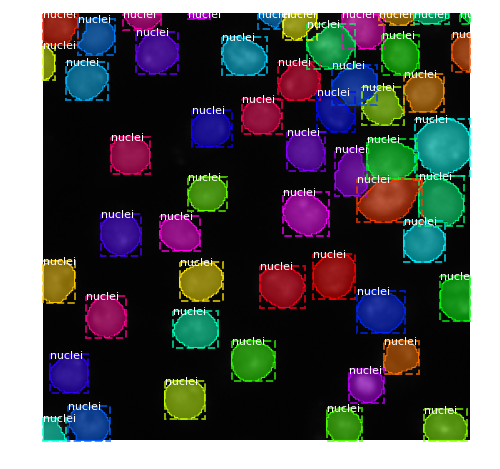

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    2.00000  max:  135.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -121.70000  max:   31.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000


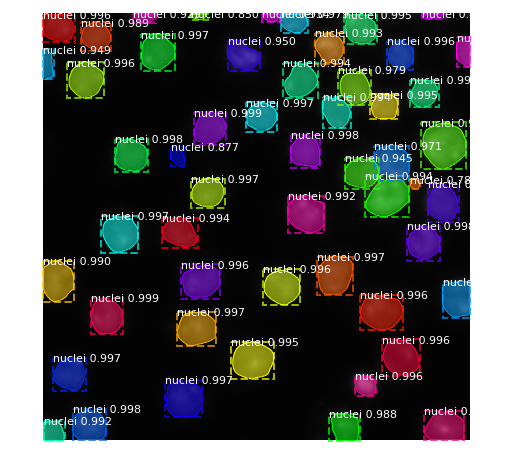

In [26]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
print(dataset_val.image_info[image_id])
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
#print(r)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

##Export Results for Submission


In [78]:
# Load test dataset
dataset_test = NucleiDataset()
dataset_test.load_nuclei(TEST_PATH, test_ids)
dataset_test.prepare()
print(len(dataset_test.image_ids))

65


In [60]:
# Test RLE encoding functions on train set masks
mask_test, _ = dataset_train.load_mask(0)

print(mask_test.shape)
print(pd.Series(mask_encode(mask_test)).apply(lambda x: ' '.join(str(y) for y in x)))


(256, 256, 16)
0     54029 16 54283 20 54539 21 54794 23 55049 25 5...
1     62016 5 62270 10 62524 15 62780 16 63035 17 63...
2     41286 5 41538 16 41794 17 42049 19 42305 19 42...
3     3834 7 4088 9 4342 11 4597 12 4852 13 5107 14 ...
4     13334 3 13587 9 13841 13 14095 16 14349 18 146...
5     22037 5 22292 10 22548 11 22804 11 23060 11 23...
6     60320 6 60574 10 60825 17 61080 20 61335 23 61...
7     55425 9 55679 11 55934 13 56189 15 56445 18 56...
8     46613 7 46866 12 47119 16 47373 18 47628 19 47...
9                         1 10 257 9 513 8 769 7 1025 4
10          64389 7 64642 11 64897 13 65153 16 65408 19
11    59137 1 59393 2 59649 6 59905 8 60161 9 60417 ...
12    43628 9 43882 13 44136 16 44391 19 44646 21 44...
13    49193 4 49445 9 49700 11 49955 12 50211 13 504...
14    59069 8 59322 14 59577 16 59832 19 60088 19 60...
15      50252 6 50507 8 50763 8 51019 8 51276 7 51533 5
dtype: object


Processing 1 images
image                    shape: (524, 348, 3)         min:    0.00000  max:  253.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000


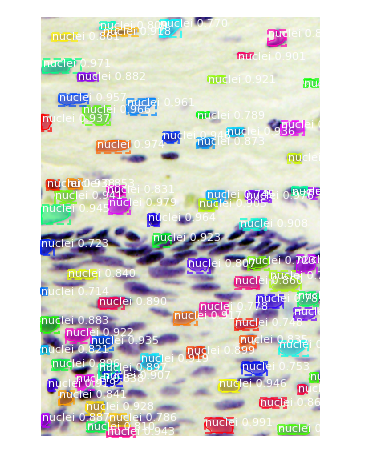

In [62]:
# Pick a test image to visualize
image = dataset_test.load_image(33)

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())

print(r['masks'].shape)

In [82]:
# Run detection on all test and do RLE encoding

new_test_ids = []
rles = []
for image_id in dataset_val.image_ids:
    print('Processing: ' + val_index[image_id])
    try:    
        image = dataset_val.load_image(image_id)
        results = model.detect([image], verbose=0)
        r = results[0]
z
        ## Save plot to "./plot" (without overlapping mask correction
        plot_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax(), title=test_ids[image_id])
    
        rle = mask_encode(remove_overlap(r['masks']))
        rles = np.append(rles, rle)
        new_test_ids.extend([val_index[image_id]] * len(rle))
    except:
        continue
print(len(rles))
print(len(new_test_ids))

Processing: 519dc0d672d1c295fc69b629af8721ccb1a1f136d1976685a68487e62547ffe0


Processing: 44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078


Processing: 5cee644e5ffbef1ba021c7f389b33bafd3b1841f04d3edd7922d5084c2c4e0c7


Overlapping mask detected!
Overlapping mask detected!
Processing: ade080c6618cbbb0a25680cf847f312b5e19b22bfe1cafec0436987ebe5b1e7e


Overlapping mask detected!
Overlapping mask detected!
Overlapping mask detected!


Processing: 17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff


Overlapping mask detected!
Processing: a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d


Processing: ca20076870e8fb604e61802605a9ac45419c82dd3e23404c56c4869f9502a5ef


Processing: 0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5


In [81]:
# Save results for submission

import pandas as pd

# Create submission DataFramevim
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('./submit/sub-dsbowl2018-6.csv', index=False)